- 인구 대비 경찰서 수 (지역별)


## 0. 필요한 라이브러리 불러오기

In [11]:
from geoband.API import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import geopandas as gpd
import seaborn as sns

import os
from tqdm import tqdm

import json
from urllib.request import Request, urlopen
from urllib.parse import urlencode, quote_plus, quote
import time

import warnings
warnings.filterwarnings(action='ignore')
from IPython.display import display

In [2]:
def fix_font():
    # From https://HC.Dle.pw, By Jinseo Kim
    # v1.0.0
    import os
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    os.system("apt-get install -y fonts-nanum")
    os.system("fc-cache -fv")
    mpl.font_manager._rebuild()
    findfont = mpl.font_manager.fontManager.findfont
    mpl.font_manager.findfont = findfont
    mpl.backends.backend_agg.findfont = findfont
    plt.rcParams['font.family'] = "NanumBarunGothic"
    plt.rcParams['axes.unicode_minus'] = False
           
fix_font()

## 1. 파출소/지구대 대비 인구수 비율

각 지역의 치안을 직접적으로 담당하는 치안센터로 분류되는 파출소, 지구대, 순찰대의 수를 살펴보겠습니다. 그리고 지역별 인구수를 살펴봄으로써 각 치안센터 당 담당하고 있는 인구수를 계산해보겠습니다.

### (1) 지역별 파출소/지구대 수 파악하기

In [3]:
GetCompasData('SBJ_2109_001', '39', '39.4개시도_경찰관서현황.csv')
police_df = pd.read_csv('39.4개시도_경찰관서현황.csv')
police_df.head()

,pname,psname,name,lon,lat,addr
0,경남청,진주경찰서,개양파출소,128.107802,35.156949,경상남도 진주시 가좌동 448-3
1,경남청,진주경찰서,금산파출소,128.148163,35.213726,경상남도 진주시 금산면 장사리 930-1
2,경남청,진주경찰서,남강지구대,128.072194,35.189701,경상남도 진주시 인사동 182-19
3,경남청,진주경찰서,대곡파출소,128.168509,35.262218,경상남도 진주시 대곡면 광석리 314-1
4,경남청,진주경찰서,문산파출소,128.164086,35.167648,경상남도 진주시 문산읍 삼곡리 1264-12


치안센터에 해당하는 '파출소', '지구대', '순찰대'를 미리 선언해주고 각 지역별 치안센터를 담을 딕셔너리를 미리 선언해줍니다.

In [5]:
security_unit = ['파출소', '지구대', '순찰대']

In [6]:
patrol_nums = dict()

#### (a) 서울 파출소/지구대 수 파악하기
* 변수 이름: 지역_police_df : 해당 지역내 경찰서 데이터프레임
* 변수 이름: 지역_patrol_df : 해당 지역내 치안센터 데이터프레임

In [8]:
seoul_police_df = police_df[police_df['pname'].str.contains('서울청') | police_df['pname'].str.contains('본청')]
seoul_police_df.head()

,pname,psname,name,lon,lat,addr
53,서울청,서울강동경찰서,강일파출소,127.173245,37.564766,강동구 강일동 678-2
54,서울청,서울강동경찰서,광나루한강순찰대,127.118314,37.545966,서울시 강동구 천호동 488-1
55,서울청,서울강동경찰서,길동지구대,127.139201,37.529455,강동구 길동 228-6
56,서울청,서울강동경찰서,둔촌파출소,127.145744,37.525358,강동구 둔촌동 115
57,서울청,서울강동경찰서,명일파출소,127.156067,37.553640,강동구 명일동 47-20


In [9]:
seoul_patrol_df = seoul_police_df[seoul_police_df['name'].str.contains('|'.join(security_unit))]
seoul_patrol_df.head()

,pname,psname,name,lon,lat,addr
53,서울청,서울강동경찰서,강일파출소,127.173245,37.564766,강동구 강일동 678-2
54,서울청,서울강동경찰서,광나루한강순찰대,127.118314,37.545966,서울시 강동구 천호동 488-1
55,서울청,서울강동경찰서,길동지구대,127.139201,37.529455,강동구 길동 228-6
56,서울청,서울강동경찰서,둔촌파출소,127.145744,37.525358,강동구 둔촌동 115
57,서울청,서울강동경찰서,명일파출소,127.156067,37.553640,강동구 명일동 47-20


관할경찰서 당 파출소, 지구대, 순찰대 수를 파악해보겠습니다.

In [10]:
seoul_patrol_per_ps = seoul_patrol_df['psname'].value_counts().reset_index()
seoul_patrol_per_ps = seoul_patrol_per_ps.rename(columns={"index": "psname", "psname": "count"})
seoul_patrol_per_ps

,psname,count
0,서울종로경찰서,13
1,서울동대문경찰서,11
2,서울광진경찰서,11
3,서울송파경찰서,10
4,서울영등포경찰서,10
5,서울강서경찰서,10
6,서울관악경찰서,9
7,서울강동경찰서,9
8,서울성동경찰서,9
9,서울혜화경찰서,8


Text(0.5, 1.0, '관할 경찰서 당 지구대, 파출소, 순찰대 수')

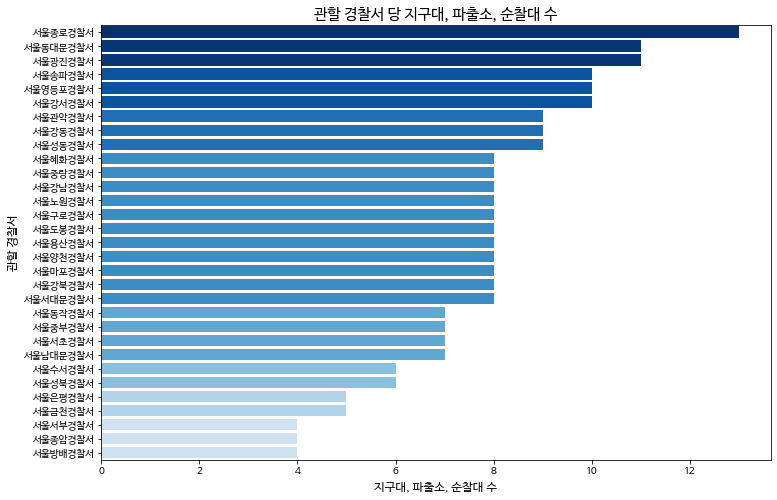

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=seoul_patrol_per_ps, y='psname', x='count', ax=ax)
widths = [p.get_width() for p in ax.patches]
w_min, w_max = min(widths), max(widths)

cmap_ = "Blues"
cmap = cm.get_cmap(cmap_)

for p in ax.patches:
    w_norm = (p.get_width() - w_min) / (w_max - w_min)
    w_norm += 0.2
    p.set_facecolor(cmap(w_norm))
    
ax.set_xlabel("지구대, 파출소, 순찰대 수", fontsize=12)
ax.set_ylabel("관할 경찰서", fontsize=12)
ax.set_title("관할 경찰서 당 지구대, 파출소, 순찰대 수", fontsize=15)

In [20]:
print(f"서울 지역 내 총 지구대, 파출소, 순찰대 수는 {len(seoul_patrol_df)}개 입니다.")
patrol_nums['서울'] = len(seoul_patrol_df)

서울 지역 내 총 지구대, 파출소, 순찰대 수는 242개 입니다.


#### (b) 수원 파출소/지구대 수 파악하기
* 변수 이름: 지역_police_df : 해당 지역내 경찰서 데이터프레임
* 변수 이름: 지역_patrol_df : 해당 지역내 치안센터 데이터프레임

In [15]:
suwon_police_df = police_df[police_df['pname'] == '경기남부청']
suwon_police_df.head()

,pname,psname,name,lon,lat,addr
196,경기남부청,수원남부경찰서,곡선지구대,127.030039,37.251801,권선구 권선동 1268-5
197,경기남부청,수원남부경찰서,광교파출소,127.047712,37.289558,경기도 수원시 영통구 이의동 1347-2
198,경기남부청,수원남부경찰서,권선파출소,127.026288,37.260749,권선구 권선동1012
199,경기남부청,수원남부경찰서,매탄지구대,127.040004,37.265157,팔달구 인계동 1117
200,경기남부청,수원남부경찰서,산남지구대,127.053029,37.268657,영통구 매탄동 1213-2


In [16]:
suwon_patrol_df = suwon_police_df[suwon_police_df['name'].str.contains('|'.join(security_unit))]
suwon_patrol_df.head()

,pname,psname,name,lon,lat,addr
196,경기남부청,수원남부경찰서,곡선지구대,127.030039,37.251801,권선구 권선동 1268-5
197,경기남부청,수원남부경찰서,광교파출소,127.047712,37.289558,경기도 수원시 영통구 이의동 1347-2
198,경기남부청,수원남부경찰서,권선파출소,127.026288,37.260749,권선구 권선동1012
199,경기남부청,수원남부경찰서,매탄지구대,127.040004,37.265157,팔달구 인계동 1117
200,경기남부청,수원남부경찰서,산남지구대,127.053029,37.268657,영통구 매탄동 1213-2


In [17]:
suwon_patrol_per_ps = suwon_patrol_df['psname'].value_counts().reset_index()
suwon_patrol_per_ps = suwon_patrol_per_ps.rename(columns={"index": "psname", "psname": "count"})
suwon_patrol_per_ps

,psname,count
0,수원남부경찰서,9
1,수원서부경찰서,7
2,수원중부경찰서,7


Text(0.5, 1.0, '관할 경찰서 당 지구대, 파출소, 순찰대 수')

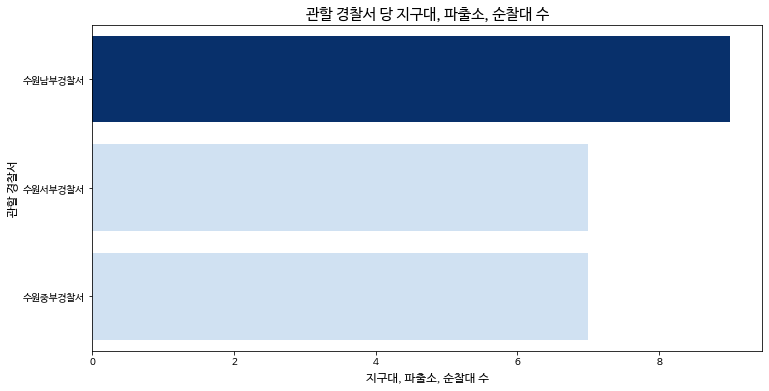

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=suwon_patrol_per_ps, y='psname', x='count', ax=ax)
widths = [p.get_width() for p in ax.patches]
w_min, w_max = min(widths), max(widths)

cmap_ = "Blues"
cmap = cm.get_cmap(cmap_)

for p in ax.patches:
    w_norm = (p.get_width() - w_min) / (w_max - w_min)
    w_norm += 0.2
    p.set_facecolor(cmap(w_norm))
    
ax.set_xlabel("지구대, 파출소, 순찰대 수", fontsize=12)
ax.set_ylabel("관할 경찰서", fontsize=12)
ax.set_title("관할 경찰서 당 지구대, 파출소, 순찰대 수", fontsize=15)

In [19]:
print(f"수원 지역 내 총 지구대, 파출소, 순찰대 수는 {len(suwon_patrol_df)}개 입니다.")
patrol_nums['수원'] = len(suwon_patrol_df)

수원 지역 내 총 지구대, 파출소, 순찰대 수는 23개 입니다.


#### (c) 창원 파출소/지구대 수 파악하기
* 변수 이름: 지역_police_df : 해당 지역내 경찰서 데이터프레임
* 변수 이름: 지역_patrol_df : 해당 지역내 치안센터 데이터프레임

In [21]:
changwon_police_df = police_df[police_df['pname'] == '경남청']
changwon_police_df = changwon_police_df[changwon_police_df['psname'] != '진주경찰서']
changwon_police_df.head()

,pname,psname,name,lon,lat,addr
14,경남청,마산동부경찰서,마산동부경찰서,128.590246,35.238139,경상남도 창원시 마산회원구 합성2동 106
15,경남청,마산동부경찰서,산호파출소,128.581844,35.218060,경상남도 창원시 마산합포구 산호동 28-20
16,경남청,마산동부경찰서,석전파출소,128.575172,35.230721,경상남도 창원시 마산회원구 석전동 248-31
17,경남청,마산동부경찰서,양덕지구대,128.590363,35.221735,경상남도 창원시 마산회원구 양덕동 164-15
18,경남청,마산동부경찰서,합성지구대,128.584807,35.240057,경상남도 창원시 마산회원구 합성동 161-28


In [22]:
changwon_patrol_df = changwon_police_df[changwon_police_df['name'].str.contains('|'.join(security_unit))]
changwon_patrol_df.head()

,pname,psname,name,lon,lat,addr
15,경남청,마산동부경찰서,산호파출소,128.581844,35.218060,경상남도 창원시 마산합포구 산호동 28-20
16,경남청,마산동부경찰서,석전파출소,128.575172,35.230721,경상남도 창원시 마산회원구 석전동 248-31
17,경남청,마산동부경찰서,양덕지구대,128.590363,35.221735,경상남도 창원시 마산회원구 양덕동 164-15
18,경남청,마산동부경찰서,합성지구대,128.584807,35.240057,경상남도 창원시 마산회원구 합성동 161-28
19,경남청,마산동부경찰서,회원파출소,128.564413,35.218226,경상남도 창원시 마산회원구 회원동 670-10


In [23]:
changwon_patrol_per_ps = changwon_patrol_df['psname'].value_counts().reset_index()
changwon_patrol_per_ps = changwon_patrol_per_ps.rename(columns={"index": "psname", "psname": "count"})
changwon_patrol_per_ps

,psname,count
0,마산중부경찰서,8
1,마산동부경찰서,7
2,창원서부경찰서,6
3,창원중부경찰서,6
4,진해경찰서,6


Text(0.5, 1.0, '관할 경찰서 당 지구대, 파출소, 순찰대 수')

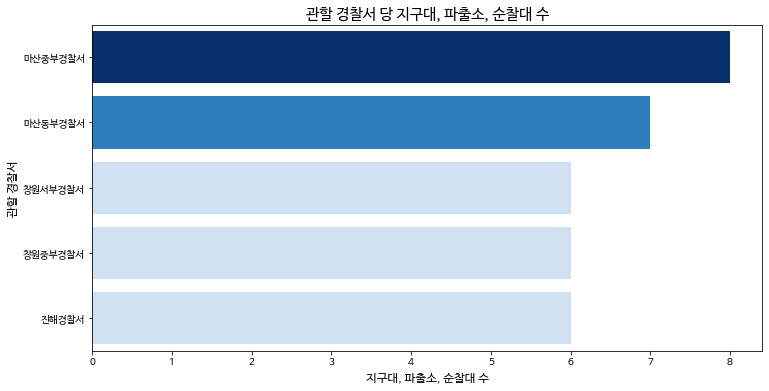

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=changwon_patrol_per_ps, y='psname', x='count', ax=ax)
widths = [p.get_width() for p in ax.patches]
w_min, w_max = min(widths), max(widths)

cmap_ = "Blues"
cmap = cm.get_cmap(cmap_)

for p in ax.patches:
    w_norm = (p.get_width() - w_min) / (w_max - w_min)
    w_norm += 0.2
    p.set_facecolor(cmap(w_norm))
    
ax.set_xlabel("지구대, 파출소, 순찰대 수", fontsize=12)
ax.set_ylabel("관할 경찰서", fontsize=12)
ax.set_title("관할 경찰서 당 지구대, 파출소, 순찰대 수", fontsize=15)

In [25]:
print(f"창원 지역 내 총 지구대, 파출소, 순찰대 수는 {len(changwon_patrol_df)}개 입니다.")
patrol_nums['창원'] = len(changwon_patrol_df)

창원 지역 내 총 지구대, 파출소, 순찰대 수는 33개 입니다.


#### (d) 진주 파출소/지구대 수 파악하기
* 변수 이름: 지역_police_df : 해당 지역내 경찰서 데이터프레임
* 변수 이름: 지역_patrol_df : 해당 지역내 치안센터 데이터프레임

In [26]:
jinju_police_df = police_df[police_df['psname'] == '진주경찰서']
jinju_police_df.head()

,pname,psname,name,lon,lat,addr
0,경남청,진주경찰서,개양파출소,128.107802,35.156949,경상남도 진주시 가좌동 448-3
1,경남청,진주경찰서,금산파출소,128.148163,35.213726,경상남도 진주시 금산면 장사리 930-1
2,경남청,진주경찰서,남강지구대,128.072194,35.189701,경상남도 진주시 인사동 182-19
3,경남청,진주경찰서,대곡파출소,128.168509,35.262218,경상남도 진주시 대곡면 광석리 314-1
4,경남청,진주경찰서,문산파출소,128.164086,35.167648,경상남도 진주시 문산읍 삼곡리 1264-12


In [27]:
jinju_patrol_df = jinju_police_df[jinju_police_df['name'].str.contains('|'.join(security_unit))]
jinju_patrol_df.head()

,pname,psname,name,lon,lat,addr
0,경남청,진주경찰서,개양파출소,128.107802,35.156949,경상남도 진주시 가좌동 448-3
1,경남청,진주경찰서,금산파출소,128.148163,35.213726,경상남도 진주시 금산면 장사리 930-1
2,경남청,진주경찰서,남강지구대,128.072194,35.189701,경상남도 진주시 인사동 182-19
3,경남청,진주경찰서,대곡파출소,128.168509,35.262218,경상남도 진주시 대곡면 광석리 314-1
4,경남청,진주경찰서,문산파출소,128.164086,35.167648,경상남도 진주시 문산읍 삼곡리 1264-12


In [28]:
jinju_patrol_per_ps = jinju_patrol_df['psname'].value_counts().reset_index()
jinju_patrol_per_ps = jinju_patrol_per_ps.rename(columns={"index": "psname", "psname": "count"})
jinju_patrol_per_ps

,psname,count
0,진주경찰서,13


Text(0.5, 1.0, '관할 경찰서 당 지구대, 파출소, 순찰대 수')

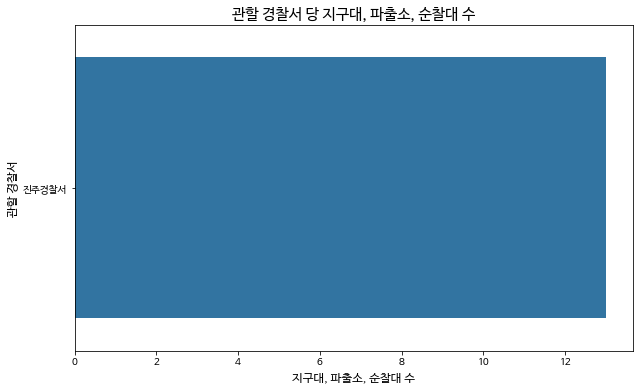

In [29]:
from matplotlib import cm

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=jinju_patrol_per_ps, y='psname', x='count', ax=ax)
    
ax.set_xlabel("지구대, 파출소, 순찰대 수", fontsize=12)
ax.set_ylabel("관할 경찰서", fontsize=12)
ax.set_title("관할 경찰서 당 지구대, 파출소, 순찰대 수", fontsize=15)

In [30]:
print(f"진주 지역 내 총 지구대, 파출소, 순찰대 수는 {len(jinju_patrol_df)}개 입니다.")
patrol_nums['진주'] = len(jinju_patrol_df)

진주 지역 내 총 지구대, 파출소, 순찰대 수는 13개 입니다.


### (2) 지역별 인구 수 파악하기

In [31]:
GetCompasData('SBJ_2109_001', '35', '35.4개시도_성연령별_총인구분포.csv')
total_pop = pd.read_csv('35.4개시도_성연령별_총인구분포.csv')
total_pop.head()

,sido,sgg_nm,age,date,popu_num,popu_male_num,popu_female_num,popu_sx_rate,local_num,local_male_num,local_female_num,local_sx_rate
0,서울특별시,종로구,합계,2017,157277,76670,80607,95.1,146298,71757,74541,96.3
1,서울특별시,종로구,0~4세,2017,4137,2099,2038,103.0,4011,2039,1972,103.4
2,서울특별시,종로구,0세,2017,694,336,358,93.9,675,327,348,94.0
3,서울특별시,종로구,1세,2017,836,429,407,105.4,805,412,393,104.8
4,서울특별시,종로구,2세,2017,878,459,419,109.5,850,447,403,110.9


인구데이터는 가장 최신 데이터인 2019년 데이터 기준으로 파악하겠습니다. 지역별 인구수를 저장할 딕셔너리를 하나 만들겠습니다.

In [32]:
total_pop_2019 = total_pop[total_pop['date'] == 2019]
total_pop_2019.head()

,sido,sgg_nm,age,date,popu_num,popu_male_num,popu_female_num,popu_sx_rate,local_num,local_male_num,local_female_num,local_sx_rate
8832,서울특별시,종로구,합계,2019,154969,74880,80089,93.5,141810,69062,72748,94.9
8833,서울특별시,종로구,0~4세,2019,3565,1778,1787,99.5,3384,1685,1699,99.2
8834,서울특별시,종로구,0세,2019,649,329,320,102.8,623,316,307,102.9
8835,서울특별시,종로구,1세,2019,583,296,287,103.1,552,280,272,102.9
8836,서울특별시,종로구,2세,2019,699,340,359,94.7,660,317,343,92.4


In [33]:
populations = dict()

#### (a) 서울 총 인구수 및 인구분포 확인하기

In [34]:
seoul_pop = total_pop_2019[total_pop_2019['sido'] == '서울특별시' ]
seoul_pop.head()

,sido,sgg_nm,age,date,popu_num,popu_male_num,popu_female_num,popu_sx_rate,local_num,local_male_num,local_female_num,local_sx_rate
8832,서울특별시,종로구,합계,2019,154969,74880,80089,93.5,141810,69062,72748,94.9
8833,서울특별시,종로구,0~4세,2019,3565,1778,1787,99.5,3384,1685,1699,99.2
8834,서울특별시,종로구,0세,2019,649,329,320,102.8,623,316,307,102.9
8835,서울특별시,종로구,1세,2019,583,296,287,103.1,552,280,272,102.9
8836,서울특별시,종로구,2세,2019,699,340,359,94.7,660,317,343,92.4


In [35]:
seoul_total_pop = seoul_pop[seoul_pop['age'] == '합계']
seoul_total_pop.head()

,sido,sgg_nm,age,date,popu_num,popu_male_num,popu_female_num,popu_sx_rate,local_num,local_male_num,local_female_num,local_sx_rate
8832,서울특별시,종로구,합계,2019,154969,74880,80089,93.5,141810,69062,72748,94.9
8960,서울특별시,중구,합계,2019,130957,63406,67551,93.9,118398,57381,61017,94.0
9088,서울특별시,용산구,합계,2019,227181,110934,116247,95.4,206678,99313,107365,92.5
9216,서울특별시,성동구,합계,2019,299688,146630,153058,95.8,287914,141020,146894,96.0
9344,서울특별시,광진구,합계,2019,359766,174027,185739,93.7,338841,164553,174288,94.4


In [36]:
seoul_total_pop['popu_num'] = seoul_total_pop['popu_num'].astype(np.int32)
seoul_total_pop['popu_male_num'] = seoul_total_pop['popu_male_num'].astype(np.int32)
seoul_total_pop['popu_female_num'] = seoul_total_pop['popu_female_num'].astype(np.int32)
seoul_total_pop['local_num'] = seoul_total_pop['local_num'].astype(np.int32)
seoul_total_pop['local_male_num'] = seoul_total_pop['local_male_num'].astype(np.int32)
seoul_total_pop['local_female_num'] = seoul_total_pop['local_female_num'].astype(np.int32)

In [37]:
seoul_pop_per_sgg = seoul_total_pop.groupby(by='sgg_nm', as_index=False)['popu_num'].sum()
seoul_pop_per_sgg = seoul_pop_per_sgg.sort_values(by='popu_num', ascending=False)
seoul_pop_per_sgg.head()

,sgg_nm,popu_num
17,송파구,648600
3,강서구,574097
8,노원구,522480
0,강남구,509199
4,관악구,507828


Text(0.5, 1.0, '행정구역 당 인구수')

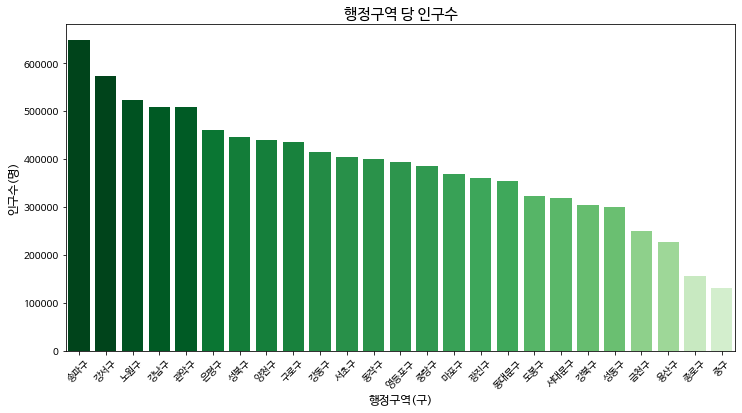

In [38]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=seoul_pop_per_sgg, x='sgg_nm', y='popu_num', ax=ax)

heights = [p.get_height() for p in ax.patches]
h_min, h_max = min(heights), max(heights)

cmap_ = "Greens"
cmap = cm.get_cmap(cmap_)

for p in ax.patches:
    h_norm = (p.get_height() - h_min) / (h_max - h_min)
    h_norm += 0.2
    p.set_facecolor(cmap(h_norm))
    
labels = [t.get_text() for t in ax.get_xticklabels()]
t = ax.set_xticklabels(labels, rotation=45)

ax.set_xlabel("행정구역(구)", fontsize=12)
ax.set_ylabel("인구수(명)", fontsize=12)
ax.set_title("행정구역 당 인구수", fontsize=15)

In [39]:
print(f"2019년 기준, 서울의 총 인구수는 {seoul_pop_per_sgg['popu_num'].sum()} 입니다.")
populations['서울'] = seoul_pop_per_sgg['popu_num'].sum()

2019년 기준, 서울의 총 인구수는 9639541 입니다.


#### (b) 수원 총 인구수 및 인구분포 확인하기

In [40]:
suwon_pop = total_pop_2019[total_pop_2019['sido'] == '경기도' ]
suwon_pop.head()

,sido,sgg_nm,age,date,popu_num,popu_male_num,popu_female_num,popu_sx_rate,local_num,local_male_num,local_female_num,local_sx_rate
12032,경기도,수원시장안구,합계,2019,282288,143174,139114,102.9,271875,137699,134176,102.6
12033,경기도,수원시장안구,0~4세,2019,8656,4434,4222,105.0,8348,4281,4067,105.3
12034,경기도,수원시장안구,0세,2019,1387,676,711,95.1,1315,638,677,94.2
12035,경기도,수원시장안구,1세,2019,1481,771,710,108.6,1417,741,676,109.6
12036,경기도,수원시장안구,2세,2019,1688,880,808,108.9,1625,855,770,111.0


In [41]:
suwon_total_pop = suwon_pop[suwon_pop['age'] == '합계']
suwon_total_pop.head()

,sido,sgg_nm,age,date,popu_num,popu_male_num,popu_female_num,popu_sx_rate,local_num,local_male_num,local_female_num,local_sx_rate
12032,경기도,수원시장안구,합계,2019,282288,143174,139114,102.9,271875,137699,134176,102.6
12160,경기도,수원시권선구,합계,2019,374770,189282,185488,102.0,359431,181368,178063,101.9
12288,경기도,수원시팔달구,합계,2019,189052,95973,93079,103.1,168601,84799,83802,101.2
12416,경기도,수원시영통구,합계,2019,368876,186064,182812,101.8,358893,180796,178097,101.5


In [43]:
suwon_total_pop['popu_num'] = suwon_total_pop['popu_num'].astype(np.int32)
suwon_total_pop['popu_male_num'] = suwon_total_pop['popu_male_num'].astype(np.int32)
suwon_total_pop['popu_female_num'] = suwon_total_pop['popu_female_num'].astype(np.int32)
suwon_total_pop['local_num'] = suwon_total_pop['local_num'].astype(np.int32)
suwon_total_pop['local_male_num'] = suwon_total_pop['local_male_num'].astype(np.int32)
suwon_total_pop['local_female_num'] = suwon_total_pop['local_female_num'].astype(np.int32)

In [44]:
suwon_pop_per_sgg = suwon_total_pop.groupby(by='sgg_nm', as_index=False)['popu_num'].sum()
suwon_pop_per_sgg = suwon_pop_per_sgg.sort_values(by='popu_num', ascending=False)
suwon_pop_per_sgg

,sgg_nm,popu_num
0,수원시권선구,374770
1,수원시영통구,368876
2,수원시장안구,282288
3,수원시팔달구,189052


Text(0.5, 1.0, '행정구역 당 인구수')

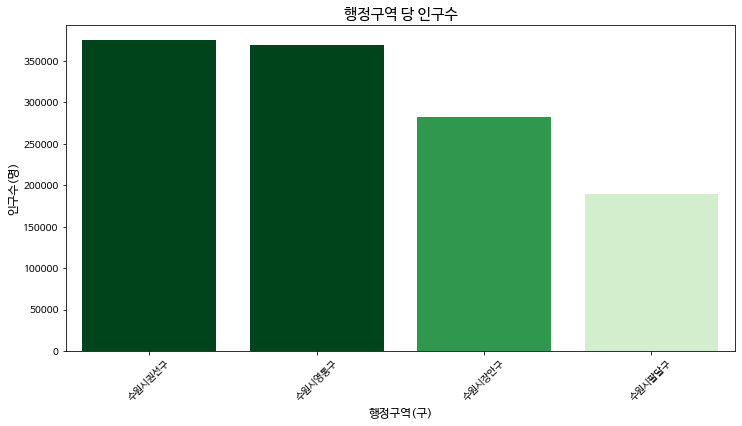

In [45]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=suwon_pop_per_sgg, x='sgg_nm', y='popu_num', ax=ax)

heights = [p.get_height() for p in ax.patches]
h_min, h_max = min(heights), max(heights)

cmap_ = "Greens"
cmap = cm.get_cmap(cmap_)

for p in ax.patches:
    h_norm = (p.get_height() - h_min) / (h_max - h_min)
    h_norm += 0.2
    p.set_facecolor(cmap(h_norm))
    
labels = [t.get_text() for t in ax.get_xticklabels()]
t = ax.set_xticklabels(labels, rotation=45)

ax.set_xlabel("행정구역(구)", fontsize=12)
ax.set_ylabel("인구수(명)", fontsize=12)
ax.set_title("행정구역 당 인구수", fontsize=15)

In [46]:
print(f"2019년 기준, 수원의 총 인구수는 {suwon_pop_per_sgg['popu_num'].sum()} 입니다.")
populations['수원'] = suwon_pop_per_sgg['popu_num'].sum()

2019년 기준, 수원의 총 인구수는 1214986 입니다.


#### (c) 창원 총 인구수 및 인구분포 확인하기

In [47]:
changwon_pop = total_pop_2019[total_pop_2019['sgg_nm'].str.contains('창원')]
changwon_pop.head()

,sido,sgg_nm,age,date,popu_num,popu_male_num,popu_female_num,popu_sx_rate,local_num,local_male_num,local_female_num,local_sx_rate
12672,경상남도,창원시의창구,합계,2019,256001,130662,125339,104.2,250901,127671,123230,103.6
12673,경상남도,창원시의창구,0~4세,2019,9828,5071,4757,106.6,9762,5037,4725,106.6
12674,경상남도,창원시의창구,0세,2019,1649,859,790,108.7,1630,849,781,108.7
12675,경상남도,창원시의창구,1세,2019,1739,880,859,102.4,1722,871,851,102.4
12676,경상남도,창원시의창구,2세,2019,1985,1040,945,110.1,1971,1035,936,110.6


In [48]:
changwon_total_pop = changwon_pop[changwon_pop['age'] == '합계']
changwon_total_pop.head()

,sido,sgg_nm,age,date,popu_num,popu_male_num,popu_female_num,popu_sx_rate,local_num,local_male_num,local_female_num,local_sx_rate
12672,경상남도,창원시의창구,합계,2019,256001,130662,125339,104.2,250901,127671,123230,103.6
12800,경상남도,창원시성산구,합계,2019,219951,114488,105463,108.6,214760,110853,103907,106.7
12928,경상남도,창원시마산합포구,합계,2019,177579,88712,88867,99.8,174434,86830,87604,99.1
13056,경상남도,창원시마산회원구,합계,2019,192446,96351,96095,100.3,189575,94740,94835,99.9
13184,경상남도,창원시진해구,합계,2019,190885,98087,92798,105.7,185968,94938,91030,104.3


In [50]:
changwon_total_pop['popu_num'] = changwon_total_pop['popu_num'].astype(np.int32)
changwon_total_pop['popu_male_num'] = changwon_total_pop['popu_male_num'].astype(np.int32)
changwon_total_pop['popu_female_num'] = changwon_total_pop['popu_female_num'].astype(np.int32)
changwon_total_pop['local_num'] = changwon_total_pop['local_num'].astype(np.int32)
changwon_total_pop['local_male_num'] = changwon_total_pop['local_male_num'].astype(np.int32)
changwon_total_pop['local_female_num'] = changwon_total_pop['local_female_num'].astype(np.int32)

In [51]:
changwon_pop_per_sgg = changwon_total_pop.groupby(by='sgg_nm', as_index=False)['popu_num'].sum()
changwon_pop_per_sgg = changwon_pop_per_sgg.sort_values(by='popu_num', ascending=False)
changwon_pop_per_sgg

,sgg_nm,popu_num
3,창원시의창구,256001
2,창원시성산구,219951
1,창원시마산회원구,192446
4,창원시진해구,190885
0,창원시마산합포구,177579


Text(0.5, 1.0, '행정구역 당 인구수')

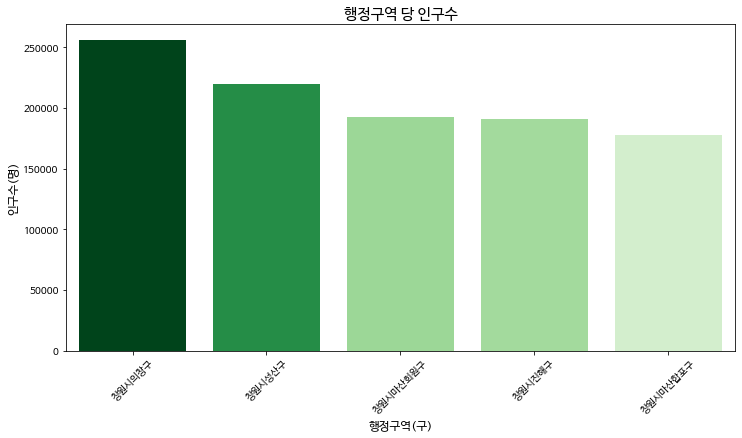

In [52]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=changwon_pop_per_sgg, x='sgg_nm', y='popu_num', ax=ax)

heights = [p.get_height() for p in ax.patches]
h_min, h_max = min(heights), max(heights)

cmap_ = "Greens"
cmap = cm.get_cmap(cmap_)

for p in ax.patches:
    h_norm = (p.get_height() - h_min) / (h_max - h_min)
    h_norm += 0.2
    p.set_facecolor(cmap(h_norm))
    
labels = [t.get_text() for t in ax.get_xticklabels()]
t = ax.set_xticklabels(labels, rotation=45)

ax.set_xlabel("행정구역(구)", fontsize=12)
ax.set_ylabel("인구수(명)", fontsize=12)
ax.set_title("행정구역 당 인구수", fontsize=15)

In [53]:
print(f"2019년 기준, 창원의 총 인구수는 {changwon_pop_per_sgg['popu_num'].sum()} 입니다.")
populations['창원'] = changwon_pop_per_sgg['popu_num'].sum()

2019년 기준, 창원의 총 인구수는 1036862 입니다.


#### (d) 진주 총 인구수 및 인구분포 확인하기

In [54]:
jinju_pop = total_pop_2019[total_pop_2019['sgg_nm'].str.contains('진주')]
jinju_pop.head()

,sido,sgg_nm,age,date,popu_num,popu_male_num,popu_female_num,popu_sx_rate,local_num,local_male_num,local_female_num,local_sx_rate
12544,경상남도,진주시,합계,2019,354166,176860,177306,99.7,347014,172576,174438,98.9
12545,경상남도,진주시,0~4세,2019,12820,6566,6254,105.0,12748,6528,6220,105.0
12546,경상남도,진주시,0세,2019,2048,1008,1040,96.9,2037,1003,1034,97.0
12547,경상남도,진주시,1세,2019,2277,1197,1080,110.8,2257,1188,1069,111.1
12548,경상남도,진주시,2세,2019,2532,1296,1236,104.9,2515,1284,1231,104.3


In [55]:
jinju_total_pop = jinju_pop[jinju_pop['age'] == '합계']
jinju_total_pop.head()

,sido,sgg_nm,age,date,popu_num,popu_male_num,popu_female_num,popu_sx_rate,local_num,local_male_num,local_female_num,local_sx_rate
12544,경상남도,진주시,합계,2019,354166,176860,177306,99.7,347014,172576,174438,98.9


In [56]:
jinju_total_pop['popu_num'] = jinju_total_pop['popu_num'].astype(np.int32)
jinju_total_pop['popu_male_num'] = jinju_total_pop['popu_male_num'].astype(np.int32)
jinju_total_pop['popu_female_num'] = jinju_total_pop['popu_female_num'].astype(np.int32)
jinju_total_pop['local_num'] = jinju_total_pop['local_num'].astype(np.int32)
jinju_total_pop['local_male_num'] = jinju_total_pop['local_male_num'].astype(np.int32)
jinju_total_pop['local_female_num'] = jinju_total_pop['local_female_num'].astype(np.int32)

In [57]:
jinju_pop_per_sgg = jinju_total_pop.groupby(by='sgg_nm', as_index=False)['popu_num'].sum()
jinju_pop_per_sgg = jinju_pop_per_sgg.sort_values(by='popu_num', ascending=False)
jinju_pop_per_sgg

,sgg_nm,popu_num
0,진주시,354166


Text(0.5, 1.0, '행정구역 당 인구수')

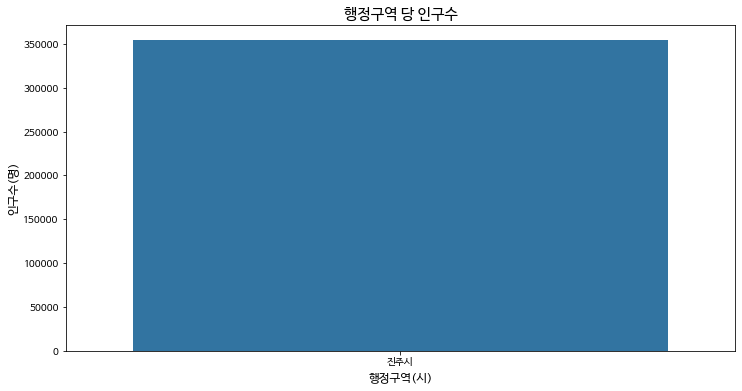

In [58]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=jinju_pop_per_sgg, x='sgg_nm', y='popu_num', ax=ax)


ax.set_xlabel("행정구역(시)", fontsize=12)
ax.set_ylabel("인구수(명)", fontsize=12)
ax.set_title("행정구역 당 인구수", fontsize=15)

In [59]:
print(f"2019년 기준, 진주의 총 인구수는 {jinju_pop_per_sgg['popu_num'].sum()} 입니다.")
populations['진주'] = jinju_pop_per_sgg['popu_num'].sum()

2019년 기준, 진주의 총 인구수는 354166 입니다.


### (3) 지역별 파출소, 지구대, 순찰대 대비 인구수

In [60]:
patrol_pop_city = pd.DataFrame([patrol_nums, populations]).T
patrol_pop_city = patrol_pop_city.rename(columns={0: '파출소 수', 1: '인구 수'})
patrol_pop_city['인구 수/파출소 수'] = patrol_pop_city['인구 수'] / patrol_pop_city['파출소 수']
patrol_pop_city

,파출소 수,인구 수,인구 수/파출소 수
서울,242,9639541,39832.814050
수원,23,1214986,52825.478261
창원,33,1036862,31420.060606
진주,13,354166,27243.538462


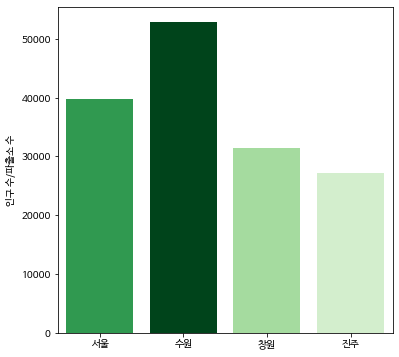

In [61]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(data=patrol_pop_city, x=patrol_pop_city.index, y='인구 수/파출소 수', ax=ax)

heights = [p.get_height() for p in ax.patches]
h_min, h_max = min(heights), max(heights)

cmap_ = "Greens"
cmap = cm.get_cmap(cmap_)

for p in ax.patches:
    h_norm = (p.get_height() - h_min) / (h_max - h_min)
    h_norm += 0.2
    p.set_facecolor(cmap(h_norm))

## 2. 신고수 대비 파출소/지구대 비율

### (1) 지역별 112신고이력 파악하기

#### (a) 서울 112 신고이력 파악하기
* 변수 이름: 지역_report : 해당 지역내 신고이력
* 변수 이름: 지역_report_per_ps : 해당 지역내 관할서당 접수된 신고 건수

지역별 신고수를 저장할 딕셔너리를 하나 만들겠습니다.

In [62]:
report_nums = dict()

In [63]:
GetCompasData('SBJ_2109_001', '3', '3.3개시도_112신고이력(관할경계매핑).csv')
other_3_report = pd.read_csv('3.3개시도_112신고이력(관할경계매핑).csv')

각 신고유형('case_type')에 따라 출동 여부가 정해질 거라 생각했습니다. 확인 결과 각 신고유형에 따라서도 출동을 하는 경우, 그렇지 않은 경우가 각각 있기 때문에 모든 신고사례를 그대로 사용하며 신고수 당 파출소, 지구대, 순찰대 수를 파악해보겠습니다.

In [64]:
seoul_report = other_3_report[(other_3_report['psname'].str.contains('서울'))]
seoul_report.head()

,case_type,rec_date,rec_time,arrival_date,name,psname
225182,교통사고,20201112,022458',20201112022950.0,당곡지구대,서울관악경찰서
225183,기타형사범,20201112,022458',20201112022515.0,가락지구대,서울송파경찰서
225184,보호조치,20201112,023136',20201112023502.0,보광파출소,서울용산경찰서
225185,기타형사범,20201112,025417',20201112025852.0,광나루지구대,서울광진경찰서
225186,기타형사범,20201112,025428',20201112025946.0,신촌지구대,서울서대문경찰서


In [65]:
seoul_report_per_ps = seoul_report.groupby(by='psname', as_index=False)['case_type'].count()
seoul_report_per_ps = seoul_report_per_ps.rename(columns={'case_type': 'report_count'})
seoul_report_per_ps = seoul_report_per_ps.sort_values(by='report_count', ascending=False)
seoul_report_per_ps.head()

,psname,report_count
20,서울송파경찰서,114438
3,서울강서경찰서,106612
23,서울영등포경찰서,103655
4,서울관악경찰서,97099
13,서울마포경찰서,91721


Text(0.5, 1.0, '관할서 당 신고수')

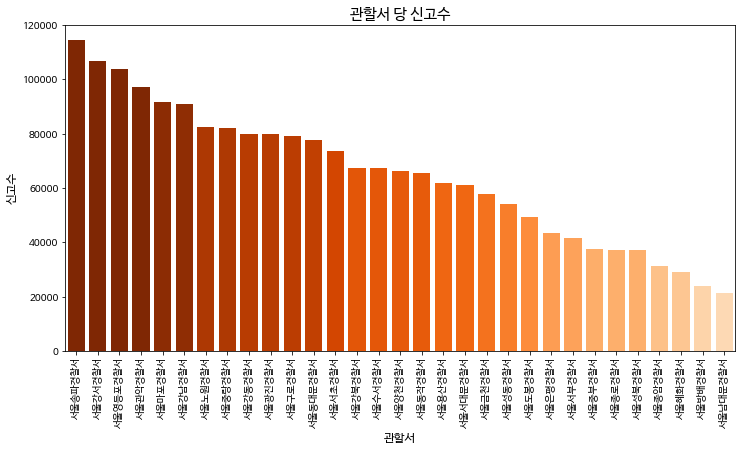

In [66]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=seoul_report_per_ps, x='psname', y='report_count', ax=ax)

heights = [p.get_height() for p in ax.patches]
h_min, h_max = min(heights), max(heights)

cmap_ = "Oranges"
cmap = cm.get_cmap(cmap_)

for p in ax.patches:
    h_norm = (p.get_height() - h_min) / (h_max - h_min)
    h_norm += 0.2
    p.set_facecolor(cmap(h_norm))
    
labels = [t.get_text() for t in ax.get_xticklabels()]
t = ax.set_xticklabels(labels, rotation=90)

ax.set_xlabel("관할서", fontsize=12)
ax.set_ylabel("신고수", fontsize=12)
ax.set_title("관할서 당 신고수", fontsize=15)

In [67]:
print(f"서울 내에 총 접수된 신고 수: {sum(seoul_report_per_ps['report_count'])}")
report_nums['서울'] = sum(seoul_report_per_ps['report_count'])

서울 내에 총 접수된 신고 수: 2012467


#### (b) 수원 112 신고이력 파악하기
* 변수 이름: 지역_report : 해당 지역내 신고이력
* 변수 이름: 지역_report_per_ps : 해당 지역내 관할서당 접수된 신고 건수

In [68]:
GetCompasData('SBJ_2109_001', '1', '1.수원시_112신고이력(격자_관할경계매핑).csv')
suwon_report = pd.read_csv('1.수원시_112신고이력(격자_관할경계매핑).csv')
suwon_report.head()

,case_type,rec_date,rec_time,arrival_date,gid,name,psname
0,비상벨,20200101,183945',NaN,다사56aa19ab,고등파출소,수원서부경찰서
1,기타_타기관,20200101,012615',20200101014135.0,다사58ab18ba,인계파출소,수원남부경찰서
2,폭력,20200101,005151',20200101005314.0,다사56bb21aa,화서문지구대,수원중부경찰서
3,소음,20200101,012608',20200101013131.0,다사57aa17ba,세류지구대,수원남부경찰서
4,분실습득,20200101,014719',NaN,다사59bb21aa,광교지구대,수원남부경찰서


In [69]:
suwon_report_per_ps = suwon_report.groupby(by='psname', as_index=False)['case_type'].count()
suwon_report_per_ps = suwon_report_per_ps.rename(columns={'case_type': 'report_count'})
suwon_report_per_ps = suwon_report_per_ps.sort_values(by='report_count', ascending=False)
suwon_report_per_ps

,psname,report_count
0,수원남부경찰서,89255
2,수원중부경찰서,73837
1,수원서부경찰서,60672


Text(0.5, 1.0, '관할서 당 신고수')

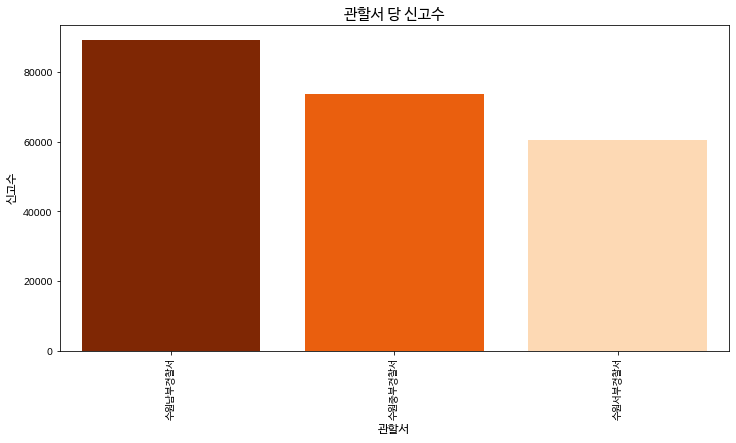

In [70]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=suwon_report_per_ps, x='psname', y='report_count', ax=ax)

heights = [p.get_height() for p in ax.patches]
h_min, h_max = min(heights), max(heights)

cmap_ = "Oranges"
cmap = cm.get_cmap(cmap_)

for p in ax.patches:
    h_norm = (p.get_height() - h_min) / (h_max - h_min)
    h_norm += 0.2
    p.set_facecolor(cmap(h_norm))
    
labels = [t.get_text() for t in ax.get_xticklabels()]
t = ax.set_xticklabels(labels, rotation=90)

ax.set_xlabel("관할서", fontsize=12)
ax.set_ylabel("신고수", fontsize=12)
ax.set_title("관할서 당 신고수", fontsize=15)

In [71]:
print(f"수원 내에 총 접수된 신고 수: {sum(suwon_report_per_ps['report_count'])}")
report_nums['수원'] = sum(suwon_report_per_ps['report_count'])

수원 내에 총 접수된 신고 수: 223764


#### (c) 창원 112 신고이력 파악하기
* 변수 이름: 지역_report : 해당 지역내 신고이력
* 변수 이름: 지역_report_per_ps : 해당 지역내 관할서당 접수된 신고 건수

In [72]:
changwon_report = other_3_report[(other_3_report['psname'].str.contains('창원')) | (other_3_report['psname'].str.contains('마산')) | (other_3_report['psname'].str.contains('진해'))]
changwon_report.head()

,case_type,rec_date,rec_time,arrival_date,name,psname
53539,시비,20200101,004920',NaN,가음정지구대,창원중부경찰서
53540,폭력,20200101,004633',20200101004900,중앙파출소,창원중부경찰서
53541,기타형사범,20200101,004658',20200101005016,동읍파출소,창원서부경찰서
53542,위험방지,20200101,004647',20200101005246,신월지구대,창원중부경찰서
53543,분실습득,20200101,014205',NaN,중앙파출소,창원중부경찰서


In [73]:
changwon_report_per_ps = changwon_report.groupby(by='psname', as_index=False)['case_type'].count()
changwon_report_per_ps = changwon_report_per_ps.rename(columns={'case_type': 'report_count'})
changwon_report_per_ps = changwon_report_per_ps.sort_values(by='report_count', ascending=False)
changwon_report_per_ps

,psname,report_count
4,창원중부경찰서,42293
0,마산동부경찰서,37637
3,창원서부경찰서,34805
1,마산중부경찰서,29444
2,진해경찰서,27464


Text(0.5, 1.0, '관할서 당 신고수')

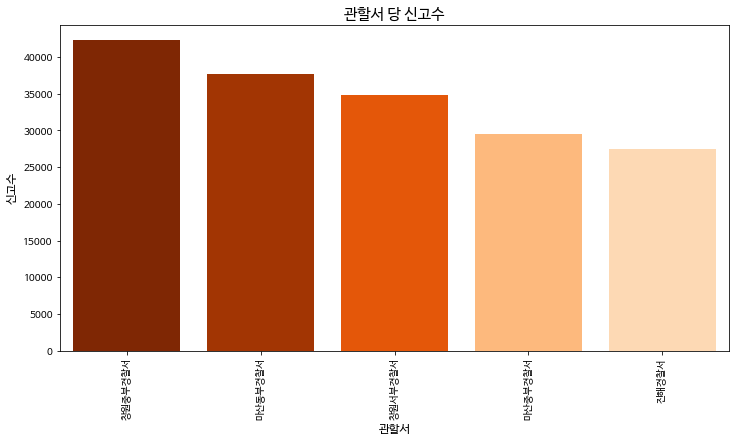

In [74]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=changwon_report_per_ps, x='psname', y='report_count', ax=ax)

heights = [p.get_height() for p in ax.patches]
h_min, h_max = min(heights), max(heights)

cmap_ = "Oranges"
cmap = cm.get_cmap(cmap_)

for p in ax.patches:
    h_norm = (p.get_height() - h_min) / (h_max - h_min)
    h_norm += 0.2
    p.set_facecolor(cmap(h_norm))
    
labels = [t.get_text() for t in ax.get_xticklabels()]
t = ax.set_xticklabels(labels, rotation=90)

ax.set_xlabel("관할서", fontsize=12)
ax.set_ylabel("신고수", fontsize=12)
ax.set_title("관할서 당 신고수", fontsize=15)

In [75]:
print(f"창원 내에 총 접수된 신고 수: {sum(changwon_report_per_ps['report_count'])}")
report_nums['창원'] = sum(changwon_report_per_ps['report_count'])

창원 내에 총 접수된 신고 수: 171643


#### (d) 진주 112 신고이력 파악하기
* 변수 이름: 지역_report : 해당 지역내 신고이력
* 변수 이름: 지역_report_per_ps : 해당 지역내 관할서당 접수된 신고 건수

In [76]:
jinju_report = other_3_report[(other_3_report['psname'].str.contains('진주'))]
jinju_report.head()

,case_type,rec_date,rec_time,arrival_date,name,psname
0,위험방지,20200101,000141',20200101001115,비봉지구대,진주경찰서
1,소음,20200101,004826',20200101004950,비봉지구대,진주경찰서
2,교통위반,20200101,014339',20200101015133,개양파출소,진주경찰서
3,위험방지,20200101,023507',20200101023915,개양파출소,진주경찰서
4,위험방지,20200101,005003',20200101005019,비봉지구대,진주경찰서


In [77]:
jinju_report_per_ps = jinju_report.groupby(by='psname', as_index=False)['case_type'].count()
jinju_report_per_ps = jinju_report_per_ps.rename(columns={'case_type': 'report_count'})
jinju_report_per_ps = jinju_report_per_ps.sort_values(by='report_count', ascending=False)
jinju_report_per_ps

,psname,report_count
0,진주경찰서,53539


Text(0.5, 1.0, '관할서 당 신고수')

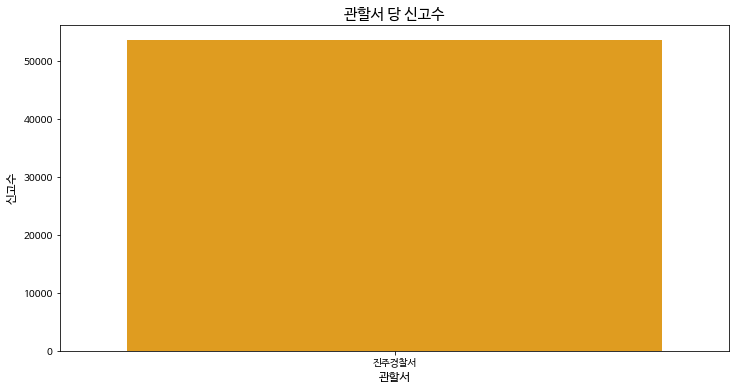

In [78]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=jinju_report_per_ps, x='psname', y='report_count', color='orange', ax=ax)

ax.set_xlabel("관할서", fontsize=12)
ax.set_ylabel("신고수", fontsize=12)
ax.set_title("관할서 당 신고수", fontsize=15)

In [79]:
print(f"진주 내에 총 접수된 신고 수: {sum(jinju_report_per_ps['report_count'])}")
report_nums['진주'] = sum(jinju_report_per_ps['report_count'])

진주 내에 총 접수된 신고 수: 53539


### (2) 지역별 신고수 당 치안센터 수 파악

In [80]:
patrol_pop_city['신고 수'] = patrol_pop_city.index.map(report_nums)
patrol_pop_city['신고 수/파출소 수'] = patrol_pop_city['신고 수'] / patrol_pop_city['파출소 수']
patrol_pop_city

,파출소 수,인구 수,인구 수/파출소 수,신고 수,신고 수/파출소 수
서울,242,9639541,39832.814050,2012467,8315.979339
수원,23,1214986,52825.478261,223764,9728.869565
창원,33,1036862,31420.060606,171643,5201.303030
진주,13,354166,27243.538462,53539,4118.384615


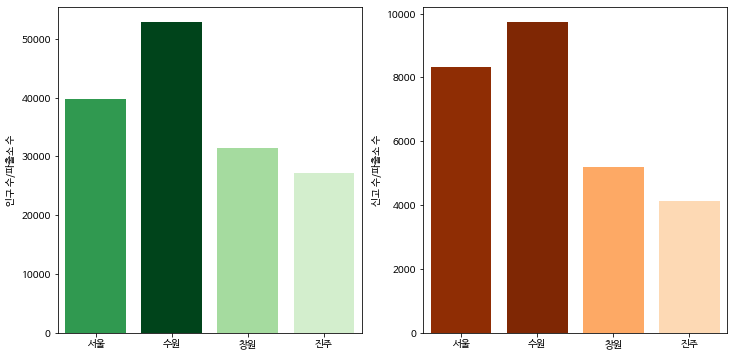

In [83]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axs = axes.ravel()

sns.barplot(data=patrol_pop_city, x=patrol_pop_city.index, y='인구 수/파출소 수', ax=axs[0])
heights = [p.get_height() for p in axs[0].patches]
h_min, h_max = min(heights), max(heights)

cmap_ = "Greens"
cmap = cm.get_cmap(cmap_)

for p in axs[0].patches:
    h_norm = (p.get_height() - h_min) / (h_max - h_min)
    h_norm += 0.2
    p.set_facecolor(cmap(h_norm))
    
sns.barplot(data=patrol_pop_city, x=patrol_pop_city.index, y='신고 수/파출소 수', ax=axs[1])

heights = [p.get_height() for p in axs[1].patches]
h_min, h_max = min(heights), max(heights)

cmap_ = "Oranges"
cmap = cm.get_cmap(cmap_)

for p in axs[1].patches:
    h_norm = (p.get_height() - h_min) / (h_max - h_min)
    h_norm += 0.2
    p.set_facecolor(cmap(h_norm))

## 3. 수원 vs 서울, 창원, 진주 비교

### (1) 사례별 신고횟수

In [85]:
suwon_report_case = suwon_report['case_type'].value_counts().reset_index()
suwon_report_case = suwon_report_case.rename(columns={'index': 'case_type', 'case_type': 'count'})

seoul_report_case = seoul_report['case_type'].value_counts().reset_index()
seoul_report_case = seoul_report_case.rename(columns={'index': 'case_type', 'case_type': 'count'})

changwon_report_case = changwon_report['case_type'].value_counts().reset_index()
changwon_report_case = changwon_report_case.rename(columns={'index': 'case_type', 'case_type': 'count'})

jinju_report_case = jinju_report['case_type'].value_counts().reset_index()
jinju_report_case = jinju_report_case.rename(columns={'index': 'case_type', 'case_type': 'count'})

Text(0.5, 1.0, '진주 사례별 신고 횟수')

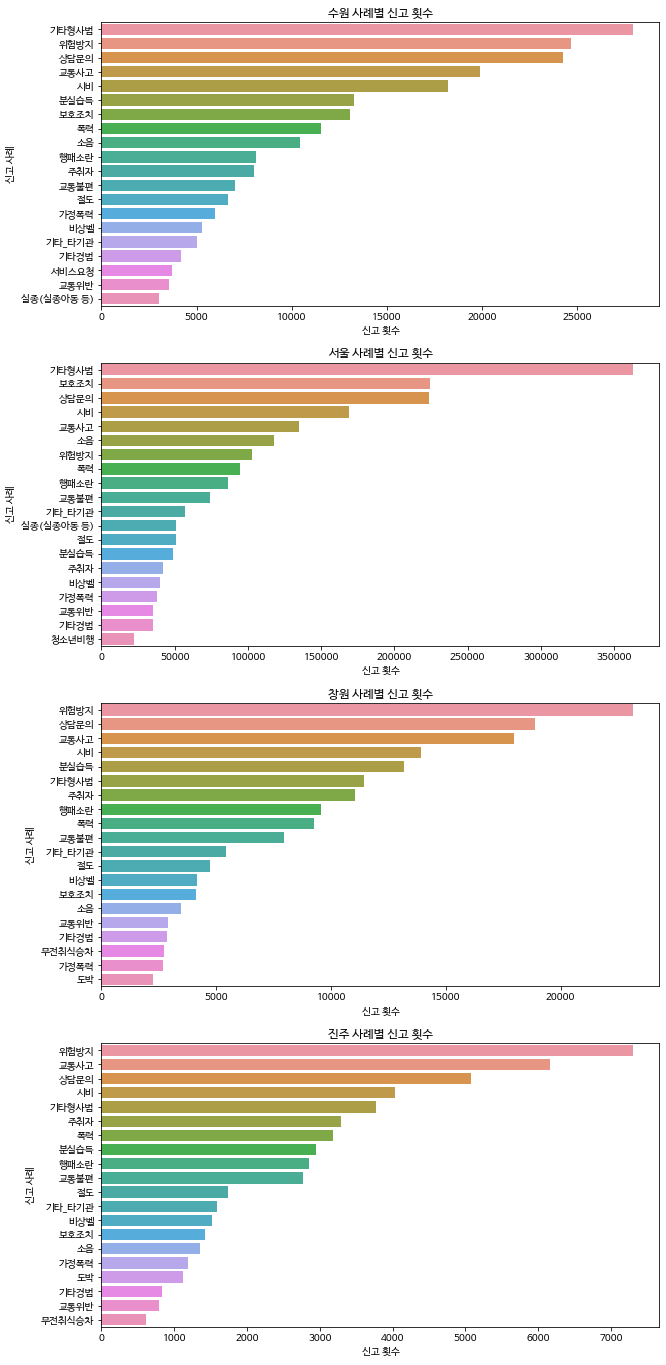

In [92]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 24))
axs = axes.ravel()

sns.barplot(data=suwon_report_case, y='case_type', x='count', ax=axs[0])
axs[0].set_ylabel("신고 사례", fontsize=10)
axs[0].set_xlabel("신고 횟수", fontsize=10)
axs[0].set_title("수원 사례별 신고 횟수", fontsize=12)

sns.barplot(data=seoul_report_case, y='case_type', x='count', ax=axs[1])
axs[1].set_ylabel("신고 사례", fontsize=10)
axs[1].set_xlabel("신고 횟수", fontsize=10)
axs[1].set_title("서울 사례별 신고 횟수", fontsize=12)

sns.barplot(data=changwon_report_case, y='case_type', x='count', ax=axs[2])
axs[2].set_ylabel("신고 사례", fontsize=10)
axs[2].set_xlabel("신고 횟수", fontsize=10)
axs[2].set_title("창원 사례별 신고 횟수", fontsize=12)

sns.barplot(data=jinju_report_case, y='case_type', x='count', ax=axs[3])
axs[3].set_ylabel("신고 사례", fontsize=10)
axs[3].set_xlabel("신고 횟수", fontsize=10)
axs[3].set_title("진주 사례별 신고 횟수", fontsize=12)


### (2) 인구분포 차이

#### (a) 수원시 인구 비율

In [110]:
suwon_pop_dist = total_pop[total_pop['sido'].str.contains('경기도')].copy()
suwon_pop_dist = suwon_pop_dist[suwon_pop_dist['age'].str.contains('~')]
suwon_pop_dist = suwon_pop_dist[suwon_pop_dist['age'] != '15~64세']

In [111]:
suwon_pop_dist_2019 = suwon_pop_dist[suwon_pop_dist['date'] == 2019]

In [112]:
suwon_pop_dist_2019['popu_num'] = suwon_pop_dist_2019['popu_num'].astype(np.int64)
suwon_pop_dist_2019['popu_male_num'] = suwon_pop_dist_2019['popu_male_num'].astype(np.int64)
suwon_pop_dist_2019['popu_female_num'] = suwon_pop_dist_2019['popu_female_num'].astype(np.int64)
suwon_pop_dist_2019['local_num'] = suwon_pop_dist_2019['local_num'].astype(np.int64)
suwon_pop_dist_2019['local_male_num'] = suwon_pop_dist_2019['local_male_num'].astype(np.int64)
suwon_pop_dist_2019['local_female_num'] = suwon_pop_dist_2019['local_female_num'].astype(np.int64)

In [113]:
suwon_age_dist = suwon_pop_dist_2019.groupby('age', as_index=False)[['popu_num', 'popu_male_num', 'popu_female_num','local_num', 'local_male_num', 'local_female_num']].sum()
suwon_age_dist['popu_local_total_rate'] = suwon_age_dist['local_num'] / suwon_age_dist['popu_num'] 
suwon_age_dist['popu_local_male_rate'] = suwon_age_dist['local_male_num'] / suwon_age_dist['popu_male_num']
suwon_age_dist['popu_local_female_rate'] = suwon_age_dist['local_female_num'] / suwon_age_dist['popu_female_num']

suwon_age_dist['popu_sx_rate'] = suwon_age_dist['popu_male_num'] / suwon_age_dist['popu_female_num']
suwon_age_dist['local_sx_rate'] = suwon_age_dist['local_male_num'] / suwon_age_dist['local_female_num']

new_index = [0, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19]
suwon_age_dist = suwon_age_dist.reindex(new_index)

suwon_age_dist.head()

,age,popu_num,popu_male_num,popu_female_num,local_num,local_male_num,local_female_num,popu_local_total_rate,popu_local_male_rate,popu_local_female_rate,popu_sx_rate,local_sx_rate
0,0~4세,48932,25229,23703,47040,24252,22788,0.961334,0.961275,0.961397,1.064380,1.064244
11,5~9세,57128,29402,27726,56014,28851,27163,0.980500,0.981260,0.979694,1.060449,1.062143
1,10~14세,55850,28685,27165,55308,28434,26874,0.990295,0.991250,0.989288,1.055954,1.058049
2,15~19세,66045,34587,31458,64958,34183,30775,0.983542,0.988319,0.978289,1.099466,1.110739
3,20~24세,87552,46075,41477,83766,44163,39603,0.956757,0.958502,0.954818,1.110857,1.115143


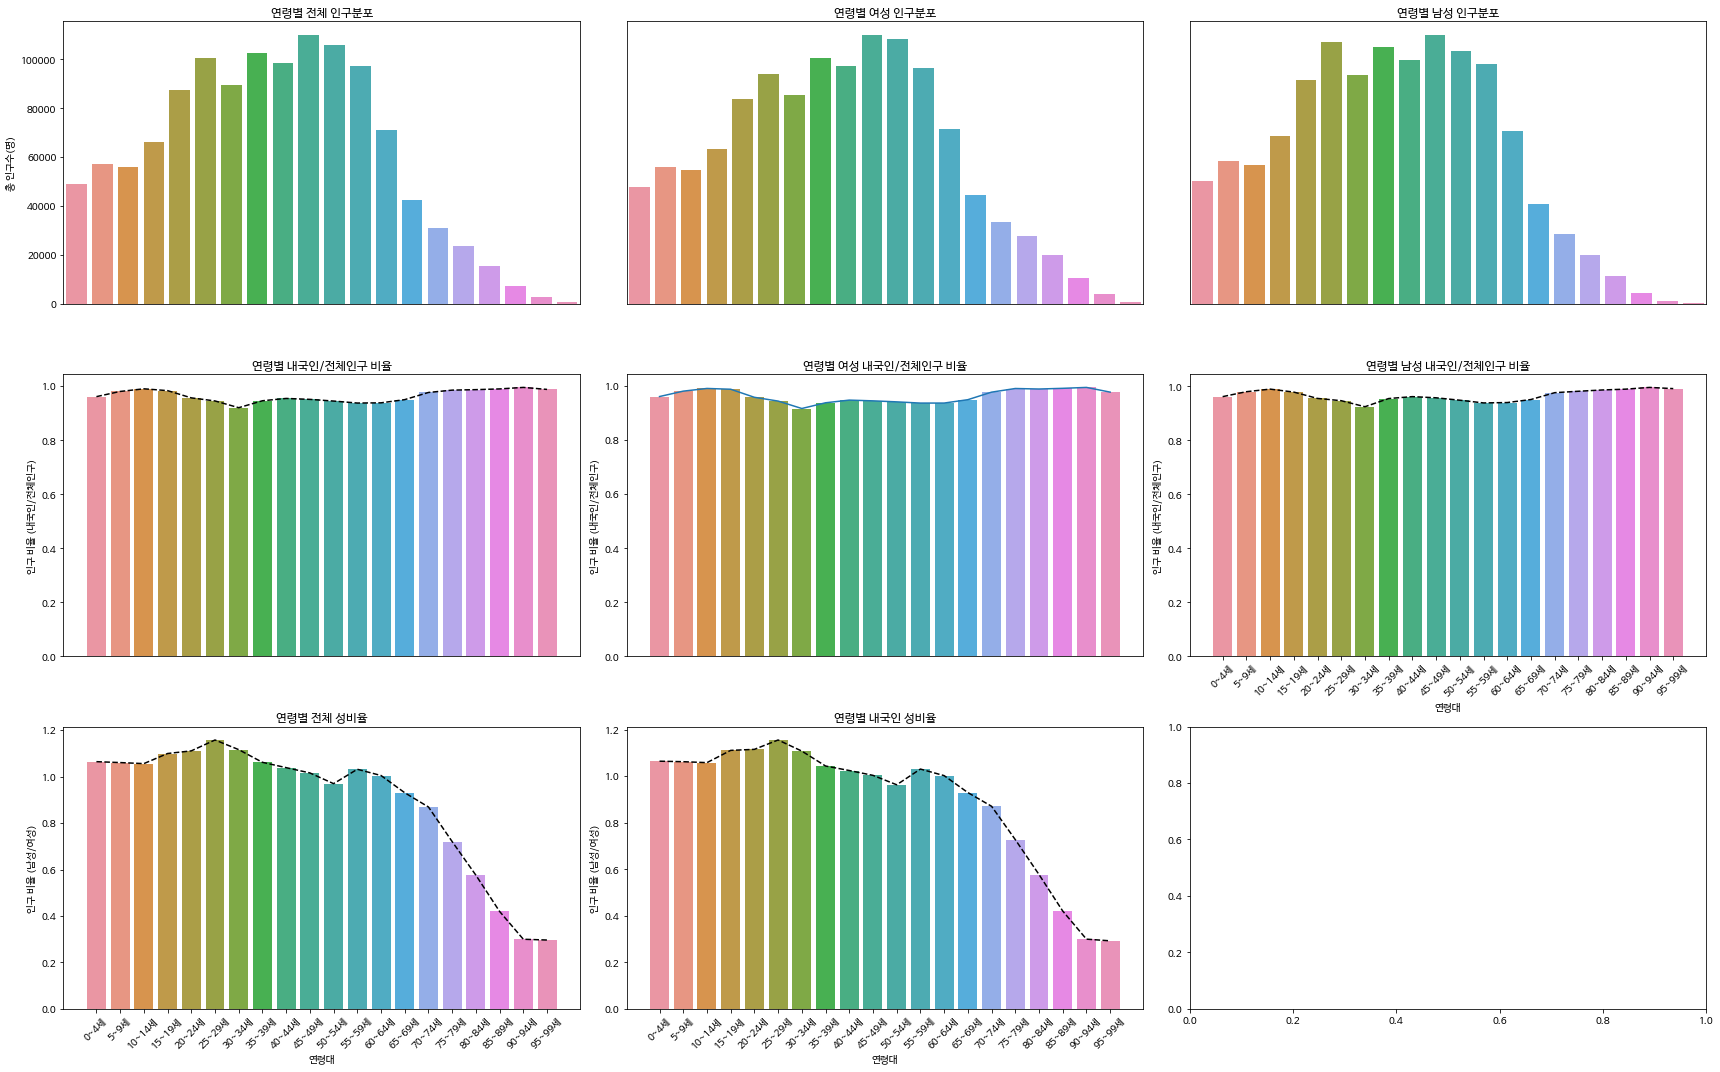

In [114]:
fig, axes = plt.subplots(figsize=(24, 15), nrows=3, ncols=3)
axs = axes.ravel()

sns.barplot(data=suwon_age_dist, x='age', y='popu_num', ax=axs[0])
axs[0].set_title("연령별 전체 인구분포")
axs[0].set_xticks([])
axs[0].set_xlabel("")
axs[0].set_ylabel("총 인구수(명)")

sns.barplot(data=suwon_age_dist, x='age', y='popu_female_num', ax=axs[1])
axs[1].set_title("연령별 여성 인구분포")
axs[1].set_xticks([])
axs[1].set_xlabel("")
axs[1].set_yticks([])
axs[1].set_ylabel("")


sns.barplot(data=suwon_age_dist, x='age', y='popu_male_num', ax=axs[2])
axs[2].set_title("연령별 남성 인구분포")
axs[2].set_xticks([])
axs[2].set_xlabel("")
axs[2].set_yticks([])
axs[2].set_ylabel("")

sns.barplot(data=suwon_age_dist, x='age', y='popu_local_total_rate', ax=axs[3])
sns.lineplot(data=suwon_age_dist, x='age', y='popu_local_total_rate', 
             ls='--', color='black', ax=axs[3])
axs[3].set_title("연령별 내국인/전체인구 비율")
axs[3].set_xticks([])
axs[3].set_xlabel("")
axs[3].set_ylabel("인구 비율 (내국인/전체인구)")

sns.barplot(data=suwon_age_dist, x='age', y='popu_local_male_rate', ax=axs[4])
sns.lineplot(data=suwon_age_dist, x='age', y='popu_local_male_rate', ax=axs[4])
axs[4].set_title("연령별 여성 내국인/전체인구 비율")
axs[4].set_xticks([])
axs[4].set_xlabel("")
axs[4].set_ylabel("인구 비율 (내국인/전체인구)")

sns.barplot(data=suwon_age_dist, x='age', y='popu_local_female_rate', ax=axs[5])
sns.lineplot(data=suwon_age_dist, x='age', y='popu_local_female_rate', 
             ls='--', color='black', ax=axs[5])
axs[5].set_title("연령별 남성 내국인/전체인구 비율")
axs[5].set_xlabel("연령대")
labels = [t.get_text() for t in axs[5].get_xticklabels()]
axs[5].set_xticklabels(labels, rotation=45)
axs[5].set_ylabel("인구 비율 (내국인/전체인구)")

sns.barplot(data=suwon_age_dist, x='age', y='popu_sx_rate', ax=axs[6])
sns.lineplot(data=suwon_age_dist, x='age', y='popu_sx_rate', 
             ls='--', color='black', ax=axs[6])
axs[6].set_title("연령별 전체 성비율")
axs[6].set_xlabel("연령대")
axs[6].set_xticklabels(labels, rotation=45)
axs[6].set_ylabel("인구 비율 (남성/여성)")

sns.barplot(data=suwon_age_dist, x='age', y='local_sx_rate', ax=axs[7])
sns.lineplot(data=suwon_age_dist, x='age', y='local_sx_rate', 
             ls='--', color='black', ax=axs[7])
axs[7].set_title("연령별 내국인 성비율")
axs[7].set_xlabel("연령대")
axs[7].set_xticklabels(labels, rotation=45)
axs[7].set_ylabel("인구 비율 (남성/여성)")


fig.tight_layout()

#### (b) 서울시 인구 비율

In [117]:
seoul_pop_dist = total_pop[total_pop['sido'].str.contains('서울특별시')].copy()
seoul_pop_dist = seoul_pop_dist[seoul_pop_dist['age'].str.contains('~')]
seoul_pop_dist = seoul_pop_dist[seoul_pop_dist['age'] != '15~64세']

In [118]:
seoul_pop_dist_2019 = seoul_pop_dist[seoul_pop_dist['date'] == 2019]

In [120]:
seoul_pop_dist_2019['popu_num'] = seoul_pop_dist_2019['popu_num'].astype(np.int64)
seoul_pop_dist_2019['popu_male_num'] = seoul_pop_dist_2019['popu_male_num'].astype(np.int64)
seoul_pop_dist_2019['popu_female_num'] = seoul_pop_dist_2019['popu_female_num'].astype(np.int64)
seoul_pop_dist_2019['local_num'] = seoul_pop_dist_2019['local_num'].astype(np.int64)
seoul_pop_dist_2019['local_male_num'] = seoul_pop_dist_2019['local_male_num'].astype(np.int64)
seoul_pop_dist_2019['local_female_num'] = seoul_pop_dist_2019['local_female_num'].astype(np.int64)

In [121]:
seoul_age_dist = seoul_pop_dist_2019.groupby('age', as_index=False)[['popu_num', 'popu_male_num', 'popu_female_num','local_num', 'local_male_num', 'local_female_num']].sum()
seoul_age_dist['popu_local_total_rate'] = seoul_age_dist['local_num'] / seoul_age_dist['popu_num'] 
seoul_age_dist['popu_local_male_rate'] = seoul_age_dist['local_male_num'] / seoul_age_dist['popu_male_num']
seoul_age_dist['popu_local_female_rate'] = seoul_age_dist['local_female_num'] / seoul_age_dist['popu_female_num']

seoul_age_dist['popu_sx_rate'] = seoul_age_dist['popu_male_num'] / seoul_age_dist['popu_female_num']
seoul_age_dist['local_sx_rate'] = seoul_age_dist['local_male_num'] / seoul_age_dist['local_female_num']

new_index = [0, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19]
seoul_age_dist = seoul_age_dist.reindex(new_index)

seoul_age_dist.head()



,age,popu_num,popu_male_num,popu_female_num,local_num,local_male_num,local_female_num,popu_local_total_rate,popu_local_male_rate,popu_local_female_rate,popu_sx_rate,local_sx_rate
0,0~4세,306901,157770,149131,296570,152446,144124,0.966338,0.966255,0.966425,1.057929,1.057742
11,5~9세,347642,178533,169109,340831,175038,165793,0.980408,0.980424,0.980391,1.055727,1.055762
1,10~14세,352373,181578,170795,348371,179550,168821,0.988643,0.988831,0.988442,1.063134,1.063553
2,15~19세,443224,222941,220283,431953,218491,213462,0.974570,0.980040,0.969035,1.012066,1.023559
3,20~24세,681005,319500,361505,630814,300486,330328,0.926299,0.940488,0.913758,0.883805,0.909659


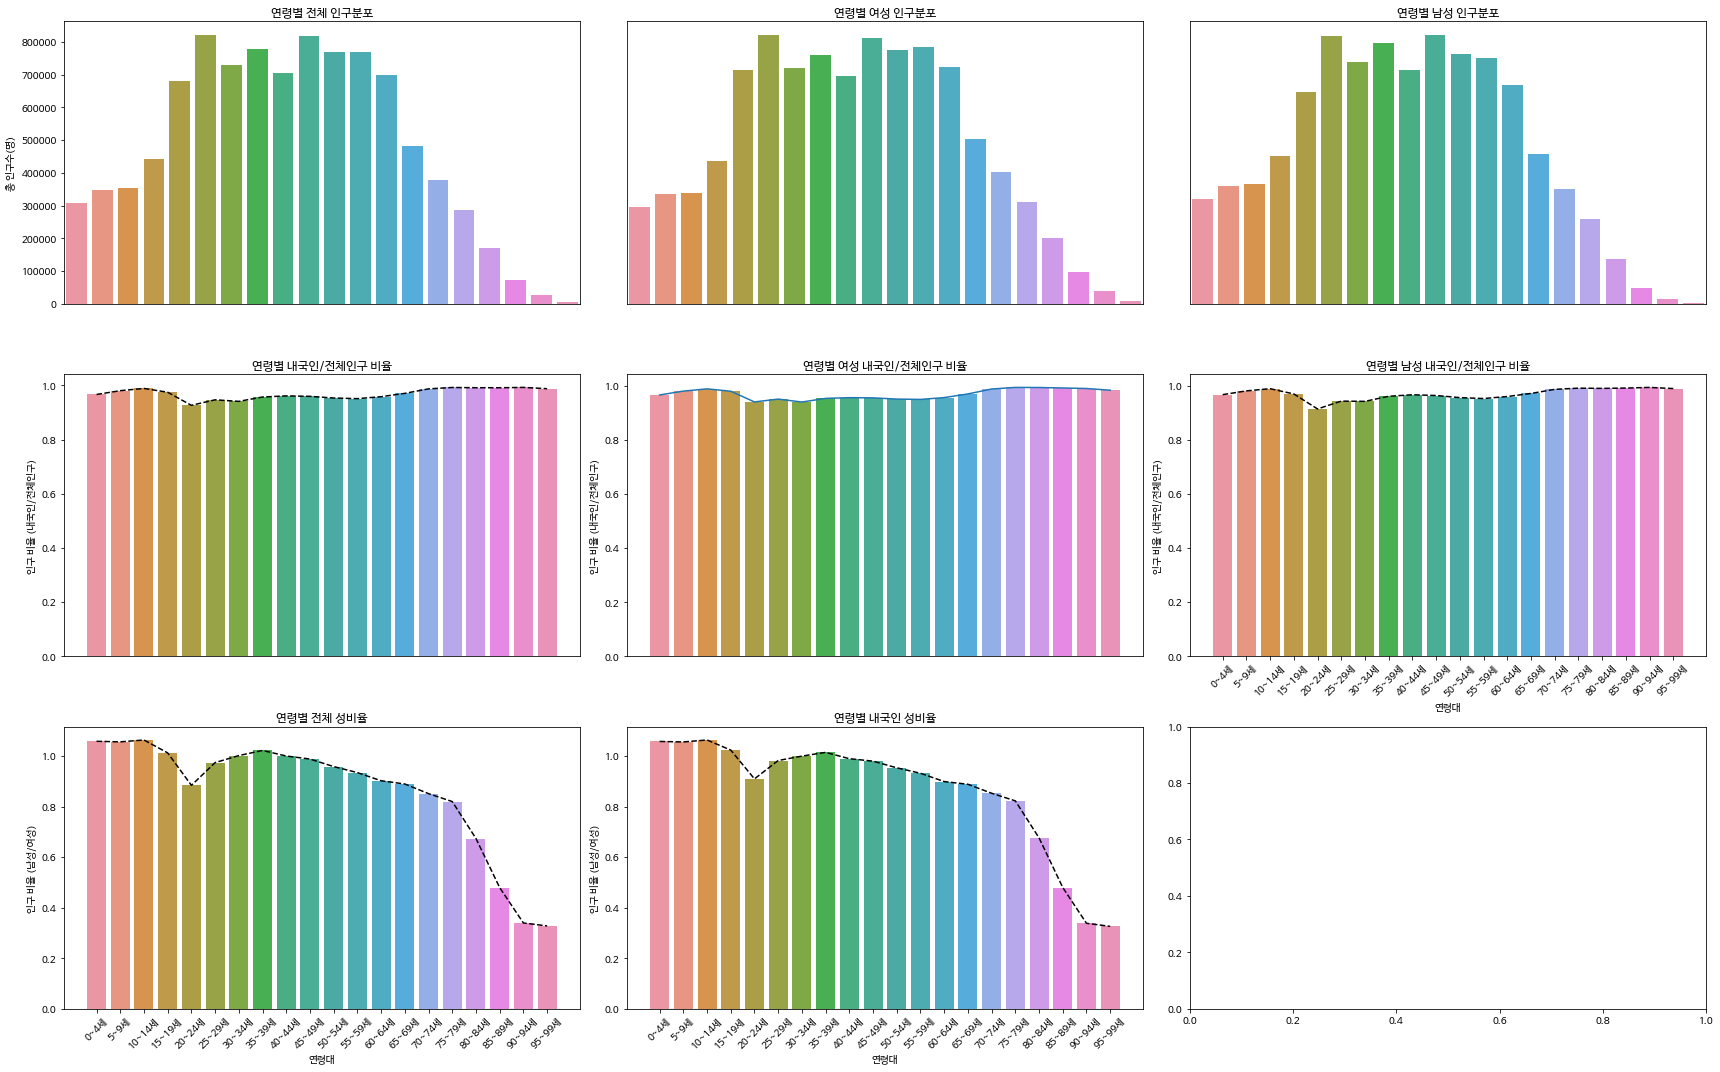

In [122]:
fig, axes = plt.subplots(figsize=(24, 15), nrows=3, ncols=3)
axs = axes.ravel()

sns.barplot(data=seoul_age_dist, x='age', y='popu_num', ax=axs[0])
axs[0].set_title("연령별 전체 인구분포")
axs[0].set_xticks([])
axs[0].set_xlabel("")
axs[0].set_ylabel("총 인구수(명)")

sns.barplot(data=seoul_age_dist, x='age', y='popu_female_num', ax=axs[1])
axs[1].set_title("연령별 여성 인구분포")
axs[1].set_xticks([])
axs[1].set_xlabel("")
axs[1].set_yticks([])
axs[1].set_ylabel("")


sns.barplot(data=seoul_age_dist, x='age', y='popu_male_num', ax=axs[2])
axs[2].set_title("연령별 남성 인구분포")
axs[2].set_xticks([])
axs[2].set_xlabel("")
axs[2].set_yticks([])
axs[2].set_ylabel("")

sns.barplot(data=seoul_age_dist, x='age', y='popu_local_total_rate', ax=axs[3])
sns.lineplot(data=seoul_age_dist, x='age', y='popu_local_total_rate', 
             ls='--', color='black', ax=axs[3])
axs[3].set_title("연령별 내국인/전체인구 비율")
axs[3].set_xticks([])
axs[3].set_xlabel("")
axs[3].set_ylabel("인구 비율 (내국인/전체인구)")

sns.barplot(data=seoul_age_dist, x='age', y='popu_local_male_rate', ax=axs[4])
sns.lineplot(data=seoul_age_dist, x='age', y='popu_local_male_rate', ax=axs[4])
axs[4].set_title("연령별 여성 내국인/전체인구 비율")
axs[4].set_xticks([])
axs[4].set_xlabel("")
axs[4].set_ylabel("인구 비율 (내국인/전체인구)")

sns.barplot(data=seoul_age_dist, x='age', y='popu_local_female_rate', ax=axs[5])
sns.lineplot(data=seoul_age_dist, x='age', y='popu_local_female_rate', 
             ls='--', color='black', ax=axs[5])
axs[5].set_title("연령별 남성 내국인/전체인구 비율")
axs[5].set_xlabel("연령대")
labels = [t.get_text() for t in axs[5].get_xticklabels()]
axs[5].set_xticklabels(labels, rotation=45)
axs[5].set_ylabel("인구 비율 (내국인/전체인구)")

sns.barplot(data=seoul_age_dist, x='age', y='popu_sx_rate', ax=axs[6])
sns.lineplot(data=seoul_age_dist, x='age', y='popu_sx_rate', 
             ls='--', color='black', ax=axs[6])
axs[6].set_title("연령별 전체 성비율")
axs[6].set_xlabel("연령대")
axs[6].set_xticklabels(labels, rotation=45)
axs[6].set_ylabel("인구 비율 (남성/여성)")

sns.barplot(data=seoul_age_dist, x='age', y='local_sx_rate', ax=axs[7])
sns.lineplot(data=seoul_age_dist, x='age', y='local_sx_rate', 
             ls='--', color='black', ax=axs[7])
axs[7].set_title("연령별 내국인 성비율")
axs[7].set_xlabel("연령대")
axs[7].set_xticklabels(labels, rotation=45)
axs[7].set_ylabel("인구 비율 (남성/여성)")


fig.tight_layout()

#### (c) 창원시 인구분포

In [96]:
changwon_pop_dist = total_pop[total_pop['sgg_nm'].str.contains('창원')].copy()
changwon_pop_dist = changwon_pop_dist[changwon_pop_dist['age'].str.contains('~')]
changwon_pop_dist = changwon_pop_dist[changwon_pop_dist['age'] != '15~64세']

In [98]:
changwon_pop_dist_2019 = changwon_pop_dist[changwon_pop_dist['date'] == 2019]

In [101]:
changwon_pop_dist_2019['popu_num'] = changwon_pop_dist_2019['popu_num'].astype(np.int64)
changwon_pop_dist_2019['popu_male_num'] = changwon_pop_dist_2019['popu_male_num'].astype(np.int64)
changwon_pop_dist_2019['popu_female_num'] = changwon_pop_dist_2019['popu_female_num'].astype(np.int64)
changwon_pop_dist_2019['local_num'] = changwon_pop_dist_2019['local_num'].astype(np.int64)
changwon_pop_dist_2019['local_male_num'] = changwon_pop_dist_2019['local_male_num'].astype(np.int64)
changwon_pop_dist_2019['local_female_num'] = changwon_pop_dist_2019['local_female_num'].astype(np.int64)

In [105]:
changwon_age_dist = changwon_pop_dist_2019.groupby('age', as_index=False)[['popu_num', 'popu_male_num', 'popu_female_num','local_num', 'local_male_num', 'local_female_num']].sum()
changwon_age_dist['popu_local_total_rate'] = changwon_age_dist['local_num'] / changwon_age_dist['popu_num'] 
changwon_age_dist['popu_local_male_rate'] = changwon_age_dist['local_male_num'] / changwon_age_dist['popu_male_num']
changwon_age_dist['popu_local_female_rate'] = changwon_age_dist['local_female_num'] / changwon_age_dist['popu_female_num']

changwon_age_dist['popu_sx_rate'] = changwon_age_dist['popu_male_num'] / changwon_age_dist['popu_female_num']
changwon_age_dist['local_sx_rate'] = changwon_age_dist['local_male_num'] / changwon_age_dist['local_female_num']

new_index = [0, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19]
changwon_age_dist = changwon_age_dist.reindex(new_index)

changwon_age_dist.head()

,age,popu_num,popu_male_num,popu_female_num,local_num,local_male_num,local_female_num,popu_local_total_rate,popu_local_male_rate,popu_local_female_rate,popu_sx_rate,local_sx_rate
0,0~4세,38710,19973,18737,38422,19827,18595,0.992560,0.992690,0.992421,1.065966,1.066254
11,5~9세,48870,25342,23528,48707,25260,23447,0.996665,0.996764,0.996557,1.077100,1.077323
1,10~14세,47413,24624,22789,47315,24576,22739,0.997933,0.998051,0.997806,1.080521,1.080786
2,15~19세,52454,28265,24189,52111,28112,23999,0.993461,0.994587,0.992145,1.168506,1.171382
3,20~24세,63555,36101,27454,61488,34874,26614,0.967477,0.966012,0.969403,1.314963,1.310363


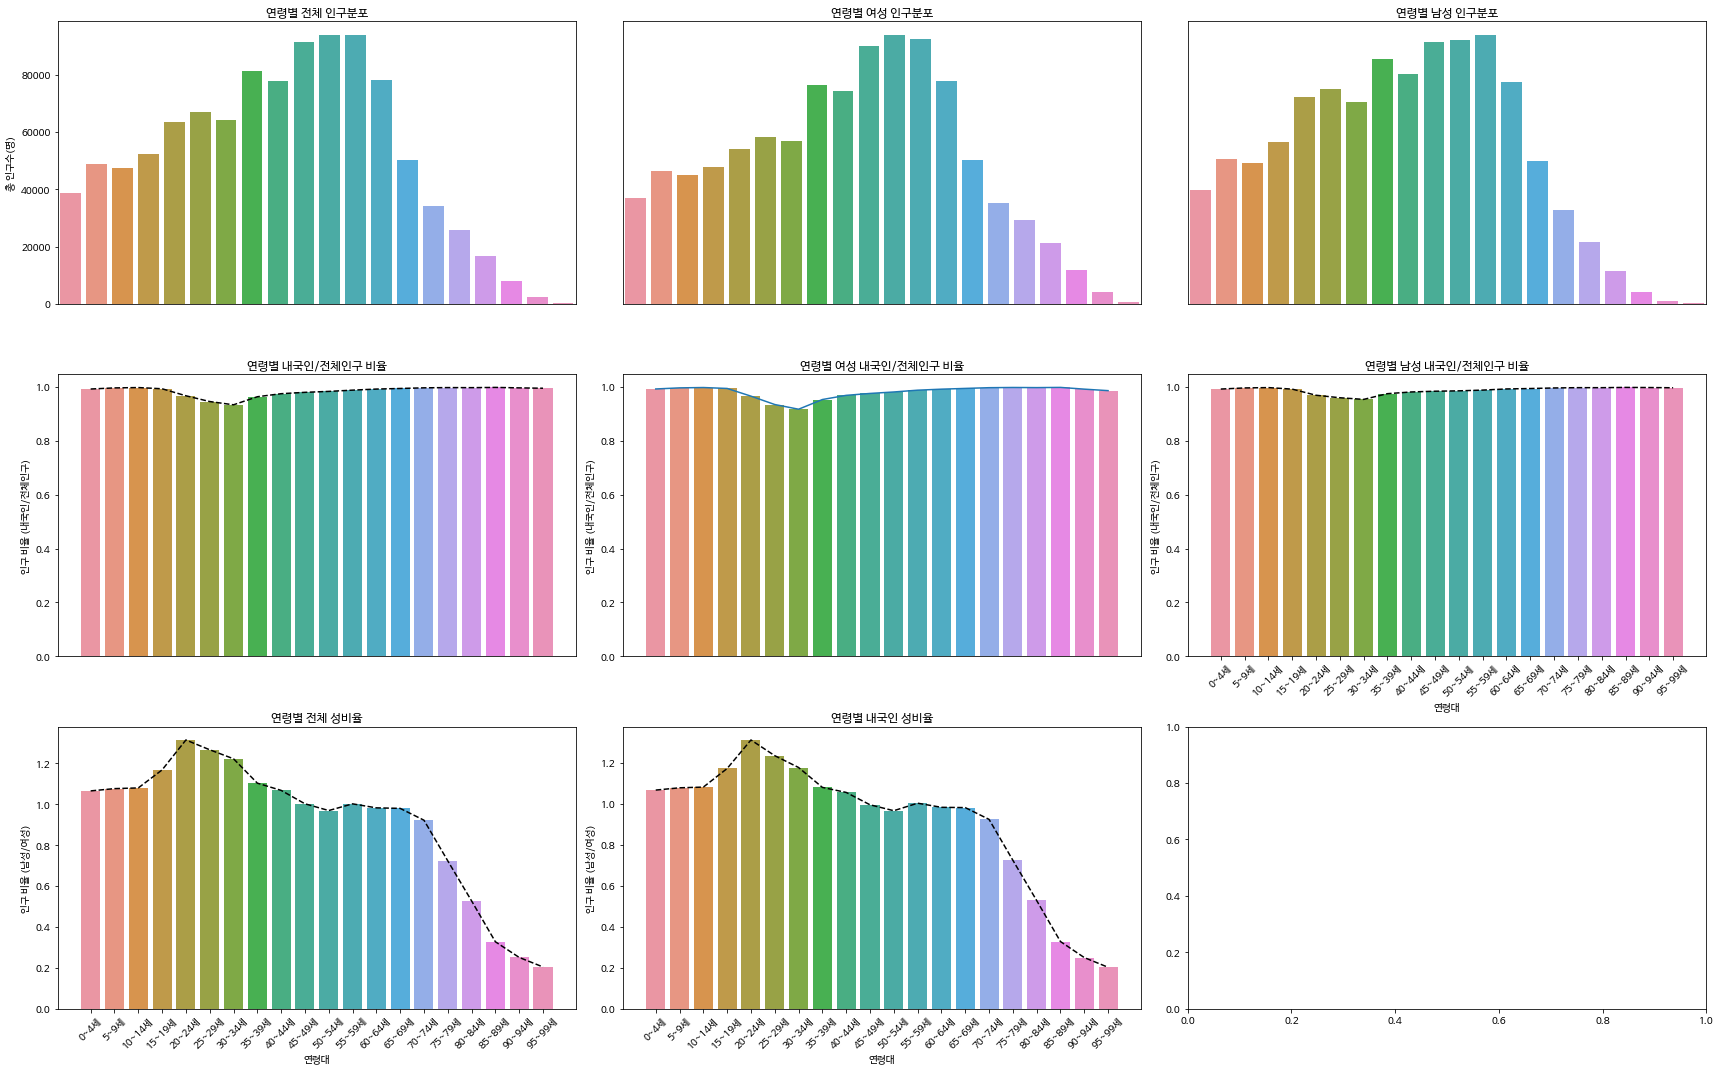

In [106]:
fig, axes = plt.subplots(figsize=(24, 15), nrows=3, ncols=3)
axs = axes.ravel()

sns.barplot(data=changwon_age_dist, x='age', y='popu_num', ax=axs[0])
axs[0].set_title("연령별 전체 인구분포")
axs[0].set_xticks([])
axs[0].set_xlabel("")
axs[0].set_ylabel("총 인구수(명)")

sns.barplot(data=changwon_age_dist, x='age', y='popu_female_num', ax=axs[1])
axs[1].set_title("연령별 여성 인구분포")
axs[1].set_xticks([])
axs[1].set_xlabel("")
axs[1].set_yticks([])
axs[1].set_ylabel("")


sns.barplot(data=changwon_age_dist, x='age', y='popu_male_num', ax=axs[2])
axs[2].set_title("연령별 남성 인구분포")
axs[2].set_xticks([])
axs[2].set_xlabel("")
axs[2].set_yticks([])
axs[2].set_ylabel("")

sns.barplot(data=changwon_age_dist, x='age', y='popu_local_total_rate', ax=axs[3])
sns.lineplot(data=changwon_age_dist, x='age', y='popu_local_total_rate', 
             ls='--', color='black', ax=axs[3])
axs[3].set_title("연령별 내국인/전체인구 비율")
axs[3].set_xticks([])
axs[3].set_xlabel("")
axs[3].set_ylabel("인구 비율 (내국인/전체인구)")

sns.barplot(data=changwon_age_dist, x='age', y='popu_local_male_rate', ax=axs[4])
sns.lineplot(data=changwon_age_dist, x='age', y='popu_local_male_rate', ax=axs[4])
axs[4].set_title("연령별 여성 내국인/전체인구 비율")
axs[4].set_xticks([])
axs[4].set_xlabel("")
axs[4].set_ylabel("인구 비율 (내국인/전체인구)")

sns.barplot(data=changwon_age_dist, x='age', y='popu_local_female_rate', ax=axs[5])
sns.lineplot(data=changwon_age_dist, x='age', y='popu_local_female_rate', 
             ls='--', color='black', ax=axs[5])
axs[5].set_title("연령별 남성 내국인/전체인구 비율")
axs[5].set_xlabel("연령대")
labels = [t.get_text() for t in axs[5].get_xticklabels()]
axs[5].set_xticklabels(labels, rotation=45)
axs[5].set_ylabel("인구 비율 (내국인/전체인구)")

sns.barplot(data=changwon_age_dist, x='age', y='popu_sx_rate', ax=axs[6])
sns.lineplot(data=changwon_age_dist, x='age', y='popu_sx_rate', 
             ls='--', color='black', ax=axs[6])
axs[6].set_title("연령별 전체 성비율")
axs[6].set_xlabel("연령대")
axs[6].set_xticklabels(labels, rotation=45)
axs[6].set_ylabel("인구 비율 (남성/여성)")

sns.barplot(data=changwon_age_dist, x='age', y='local_sx_rate', ax=axs[7])
sns.lineplot(data=changwon_age_dist, x='age', y='local_sx_rate', 
             ls='--', color='black', ax=axs[7])
axs[7].set_title("연령별 내국인 성비율")
axs[7].set_xlabel("연령대")
axs[7].set_xticklabels(labels, rotation=45)
axs[7].set_ylabel("인구 비율 (남성/여성)")


fig.tight_layout()

#### (d) 진주시 인구분포

In [124]:
jinju_pop_dist = total_pop[total_pop['sgg_nm'].str.contains('진주')].copy()
jinju_pop_dist = jinju_pop_dist[jinju_pop_dist['age'].str.contains('~')]
jinju_pop_dist = jinju_pop_dist[jinju_pop_dist['age'] != '15~64세']

In [125]:
jinju_pop_dist_2019 = jinju_pop_dist[jinju_pop_dist['date'] == 2019]

In [126]:
jinju_pop_dist_2019['popu_num'] = jinju_pop_dist_2019['popu_num'].astype(np.int64)
jinju_pop_dist_2019['popu_male_num'] = jinju_pop_dist_2019['popu_male_num'].astype(np.int64)
jinju_pop_dist_2019['popu_female_num'] = jinju_pop_dist_2019['popu_female_num'].astype(np.int64)
jinju_pop_dist_2019['local_num'] = jinju_pop_dist_2019['local_num'].astype(np.int64)
jinju_pop_dist_2019['local_male_num'] = jinju_pop_dist_2019['local_male_num'].astype(np.int64)
jinju_pop_dist_2019['local_female_num'] = jinju_pop_dist_2019['local_female_num'].astype(np.int64)

In [127]:
jinju_age_dist = jinju_pop_dist_2019.groupby('age', as_index=False)[['popu_num', 'popu_male_num', 'popu_female_num','local_num', 'local_male_num', 'local_female_num']].sum()
jinju_age_dist['popu_local_total_rate'] = jinju_age_dist['local_num'] / jinju_age_dist['popu_num'] 
jinju_age_dist['popu_local_male_rate'] = jinju_age_dist['local_male_num'] / jinju_age_dist['popu_male_num']
jinju_age_dist['popu_local_female_rate'] = jinju_age_dist['local_female_num'] / jinju_age_dist['popu_female_num']

jinju_age_dist['popu_sx_rate'] = jinju_age_dist['popu_male_num'] / jinju_age_dist['popu_female_num']
jinju_age_dist['local_sx_rate'] = jinju_age_dist['local_male_num'] / jinju_age_dist['local_female_num']

new_index = [0, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19]
jinju_age_dist = jinju_age_dist.reindex(new_index)

jinju_age_dist.head()

,age,popu_num,popu_male_num,popu_female_num,local_num,local_male_num,local_female_num,popu_local_total_rate,popu_local_male_rate,popu_local_female_rate,popu_sx_rate,local_sx_rate
0,0~4세,12820,6566,6254,12748,6528,6220,0.994384,0.994213,0.994563,1.049888,1.049518
11,5~9세,16702,8800,7902,16658,8773,7885,0.997366,0.996932,0.997849,1.113642,1.112619
1,10~14세,16592,8638,7954,16573,8626,7947,0.998855,0.998611,0.999120,1.085994,1.085441
2,15~19세,20596,11054,9542,20307,10905,9402,0.985968,0.986521,0.985328,1.158457,1.159860
3,20~24세,28020,15421,12599,26847,14777,12070,0.958137,0.958239,0.958013,1.223986,1.224275


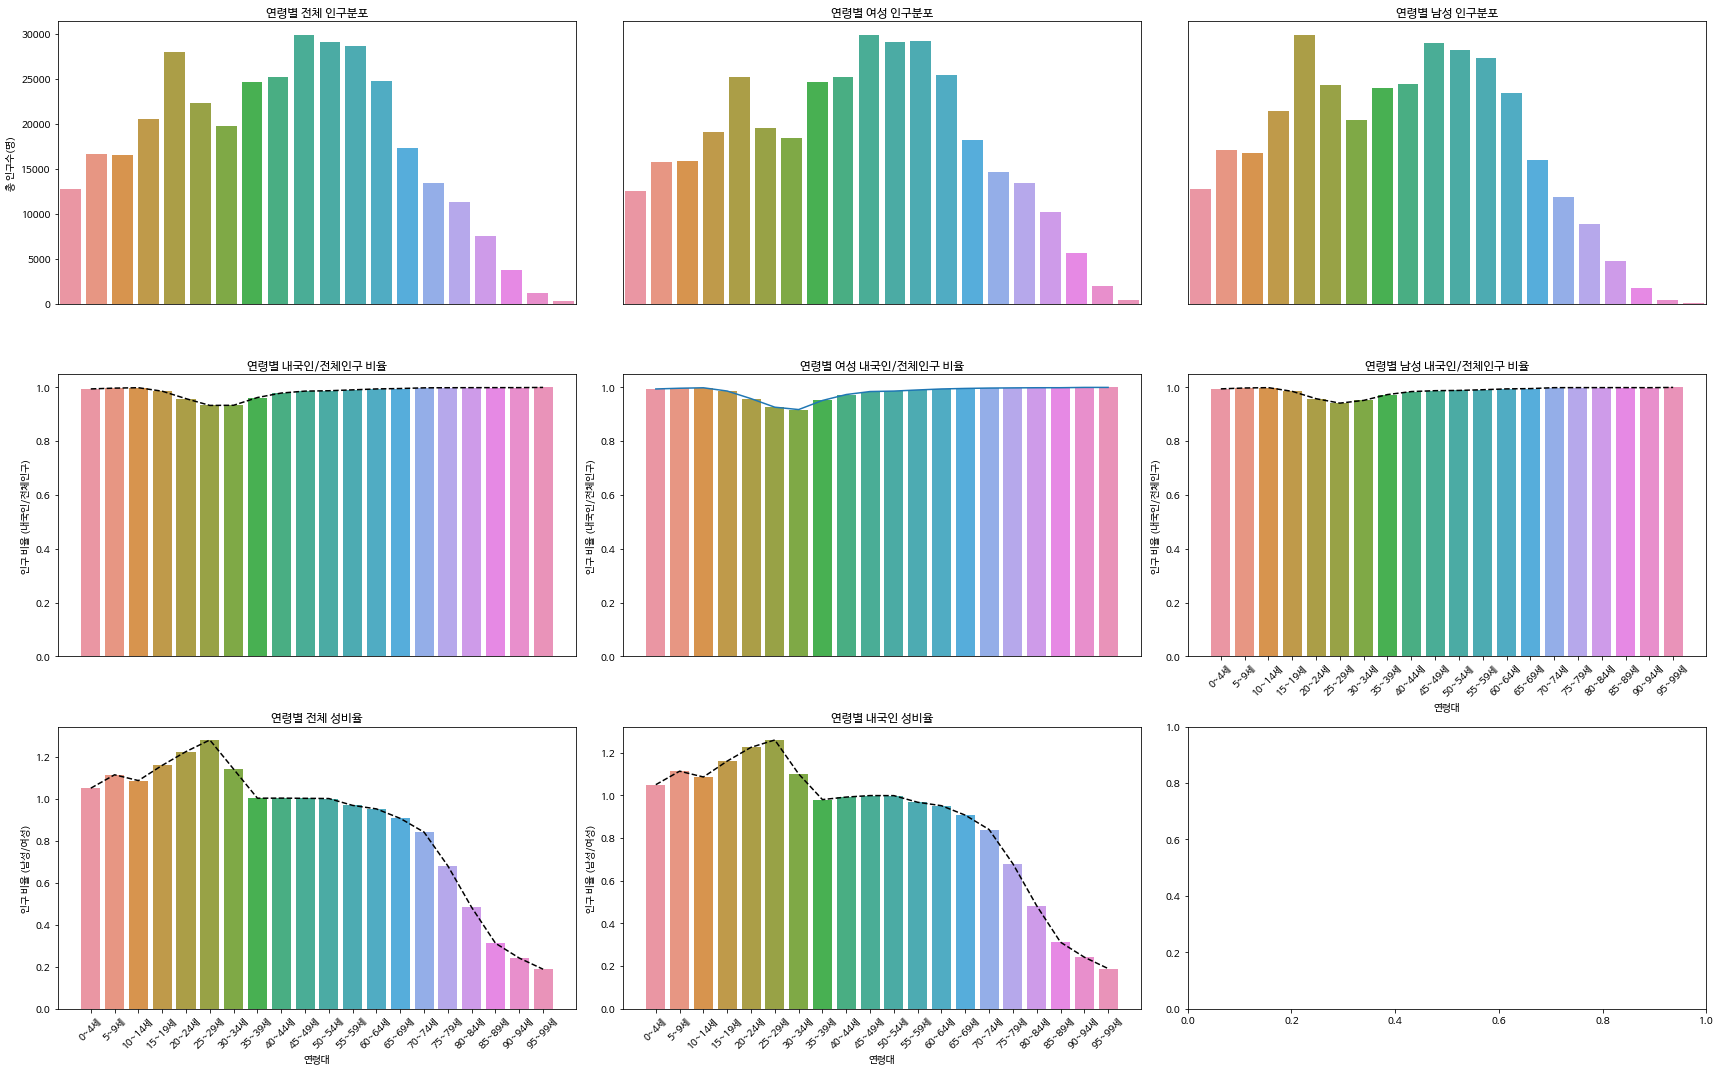

In [128]:
fig, axes = plt.subplots(figsize=(24, 15), nrows=3, ncols=3)
axs = axes.ravel()

sns.barplot(data=jinju_age_dist, x='age', y='popu_num', ax=axs[0])
axs[0].set_title("연령별 전체 인구분포")
axs[0].set_xticks([])
axs[0].set_xlabel("")
axs[0].set_ylabel("총 인구수(명)")

sns.barplot(data=jinju_age_dist, x='age', y='popu_female_num', ax=axs[1])
axs[1].set_title("연령별 여성 인구분포")
axs[1].set_xticks([])
axs[1].set_xlabel("")
axs[1].set_yticks([])
axs[1].set_ylabel("")


sns.barplot(data=jinju_age_dist, x='age', y='popu_male_num', ax=axs[2])
axs[2].set_title("연령별 남성 인구분포")
axs[2].set_xticks([])
axs[2].set_xlabel("")
axs[2].set_yticks([])
axs[2].set_ylabel("")

sns.barplot(data=jinju_age_dist, x='age', y='popu_local_total_rate', ax=axs[3])
sns.lineplot(data=jinju_age_dist, x='age', y='popu_local_total_rate', 
             ls='--', color='black', ax=axs[3])
axs[3].set_title("연령별 내국인/전체인구 비율")
axs[3].set_xticks([])
axs[3].set_xlabel("")
axs[3].set_ylabel("인구 비율 (내국인/전체인구)")

sns.barplot(data=jinju_age_dist, x='age', y='popu_local_male_rate', ax=axs[4])
sns.lineplot(data=jinju_age_dist, x='age', y='popu_local_male_rate', ax=axs[4])
axs[4].set_title("연령별 여성 내국인/전체인구 비율")
axs[4].set_xticks([])
axs[4].set_xlabel("")
axs[4].set_ylabel("인구 비율 (내국인/전체인구)")

sns.barplot(data=jinju_age_dist, x='age', y='popu_local_female_rate', ax=axs[5])
sns.lineplot(data=jinju_age_dist, x='age', y='popu_local_female_rate', 
             ls='--', color='black', ax=axs[5])
axs[5].set_title("연령별 남성 내국인/전체인구 비율")
axs[5].set_xlabel("연령대")
labels = [t.get_text() for t in axs[5].get_xticklabels()]
axs[5].set_xticklabels(labels, rotation=45)
axs[5].set_ylabel("인구 비율 (내국인/전체인구)")

sns.barplot(data=jinju_age_dist, x='age', y='popu_sx_rate', ax=axs[6])
sns.lineplot(data=jinju_age_dist, x='age', y='popu_sx_rate', 
             ls='--', color='black', ax=axs[6])
axs[6].set_title("연령별 전체 성비율")
axs[6].set_xlabel("연령대")
axs[6].set_xticklabels(labels, rotation=45)
axs[6].set_ylabel("인구 비율 (남성/여성)")

sns.barplot(data=jinju_age_dist, x='age', y='local_sx_rate', ax=axs[7])
sns.lineplot(data=jinju_age_dist, x='age', y='local_sx_rate', 
             ls='--', color='black', ax=axs[7])
axs[7].set_title("연령별 내국인 성비율")
axs[7].set_xlabel("연령대")
axs[7].set_xticklabels(labels, rotation=45)
axs[7].set_ylabel("인구 비율 (남성/여성)")


fig.tight_layout()